In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

### generate data

In [2]:
# Formulate constants
n = 2
N = 2000
eps_list = np.linspace(0.5, 2.5, 10)
k_init = np.array([4.,5.])

def gen_demand_cor(N,seed,x1, x2):
    np.random.seed(seed)
    sig = np.eye(2)
    mu = np.array((6,7))
    points_list = []
    for i in range(N):
        mu_shift = -0.4*x1 - 0.1*x2
        newpoint = np.random.multivariate_normal(mu+mu_shift,sig)
        points_list.append(newpoint)
    return np.vstack(points_list)

In [3]:
s = 1
# in order for scenario to make sense, generate only 20 contexts
np.random.seed(s)
num_context = 20
num_reps = int(N/num_context)
init_k_data = np.maximum(0.5,k_init + np.random.normal(0,3,(num_context,n)))
init_p_data = init_k_data + np.maximum(0,np.random.normal(0,3,(num_context,n)))
p_data = np.repeat(init_p_data,num_reps,axis=0)
k_data = np.repeat(init_k_data,num_reps,axis=0)

# uncertain data depends on the contexts
seed = 5
init_data = [gen_demand_cor(num_reps,seed=seed,x1=init_p_data[i],x2=init_k_data[i]) for i in range(num_context)] 
data = np.vstack(init_data)
test_p = 0.5
valid_p = 0.2

# split dataset
test_indices = np.random.choice(num_reps,int((test_p)*num_reps), replace=False)
# test_indices = testv_indices[:int((test_p)*num_reps)]
# valid_indices = testv_indices[int((test_p)*num_reps):]
train_indices = [i for i in range(num_reps) if i not in test_indices]

train = np.array([init_data[j][i] for i in train_indices for j in range(num_context)])
test = np.array([init_data[j][i] for i in test_indices for j in range(num_context)])
# valid = np.array([init_data[j][i] for i in test_indices for j in range(num_context)])

In [4]:
def calc_eval(x,p,k,u,t):
    val = 0
    vio = 0
    for i in range(u.shape[0]):
        val_cur = k@x + np.max([-p[0]*x[0] - p[1]*x[1],-p[0]*x[0] - p[1]*u[i][1], -p[0]*u[i][0] - p[1]*x[1], -p[0]*u[i][0]- p[1]*u[i][1]]) 
        val+= val_cur
        vio += (val_cur >= t)
    return val/u.shape[0], vio/u.shape[0]
context_evals = 0
context_probs = 0
# solve for each context and average
for context in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=init_data[context][train_indices]))
    x_s = cp.Variable(n)
    t1 = cp.Variable()
    k1= init_k_data[context]
    p1 = init_p_data[context]
    objective = cp.Minimize(t1)
    constraints = [lropt.max_of_uncertain([-p1[0]*x_s[0] - p1[1]*x_s[1],
                                            -p1[0]*x_s[0] - p1[1]*u[1],
                                            -p1[0]*u[0] - p1[1]*x_s[1],
                                            -p1[0]*u[0]- p1[1]*u[1]])
                                            + k1@x_s <= t1]
    constraints += [x_s >= 0]

    prob_sc = lropt.RobustProblem(objective, constraints)
    prob_sc.solve()
    eval, prob_vio = calc_eval(x_s.value, init_p_data[context], init_k_data[context],init_data[context][test_indices],t1.value)
    context_evals += eval
    context_probs += prob_vio
context_evals = context_evals/num_context
context_probs = context_probs/num_context
print(context_evals, context_probs)

nonrob_evals = 0
nonrob_probs = 0
for context in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=np.mean(init_data[context][train_indices],axis=0).reshape(1,2)))
    x_s = cp.Variable(n)
    t1 = cp.Variable()
    k1= init_k_data[context]
    p1 = init_p_data[context]
    objective = cp.Minimize(t1)
    constraints = [lropt.max_of_uncertain([-p1[0]*x_s[0] - p1[1]*x_s[1],
                                            -p1[0]*x_s[0] - p1[1]*u[1],
                                            -p1[0]*u[0] - p1[1]*x_s[1],
                                            -p1[0]*u[0]- p1[1]*u[1]])
                                            + k1@x_s <= t1]
    constraints += [x_s >= 0]

    prob_sc = lropt.RobustProblem(objective, constraints)
    prob_sc.solve()

    eval, prob_vio = calc_eval(x_s.value, init_p_data[context], init_k_data[context],init_data[context][test_indices],t1.value)
    nonrob_evals += eval
    nonrob_probs += prob_vio
nonrob_evals = nonrob_evals / (num_context)
nonrob_probs = nonrob_probs / (num_context)

-4.1714488636947245 0.15100000000000002


### create lropt problem

In [5]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(
                                                    data=data))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = lropt.ContextParameter(2, data=k_data)
p = lropt.ContextParameter(2, data=p_data)
p_x = cp.Variable(n)
objective = cp.Minimize(t)
constraints = [lropt.max_of_uncertain([-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p_x[1]*u[1], -p_x[0]*u[0] - p[1]*x_r[1], -p_x[0]*u[0]- p_x[1]*u[1]]) + k@x_r <= t]
constraints += [p_x == p]
constraints += [x_r >= 0]

eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)

### train lropt problem

Training: 100%|█████████▉| 500/501 [05:45<00:00,  1.45it/s, loss=-4.21e+00, viol=3.19e+00]


[-0.7809280787483542] [np.float64(0.0)]


Training: 100%|█████████▉| 500/501 [04:51<00:00,  1.72it/s, loss=-4.47e+00, viol=2.01e+00]


[-0.7809280787483542, -3.1080394802281486] [np.float64(0.0), np.float64(0.029)]


Training: 100%|█████████▉| 500/501 [04:50<00:00,  1.72it/s, loss=-4.94e+00, viol=1.85e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534] [np.float64(0.0), np.float64(0.029), np.float64(0.037)]


Training: 100%|█████████▉| 500/501 [05:10<00:00,  1.61it/s, loss=-5.38e+00, viol=1.86e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045)]


Training: 100%|█████████▉| 500/501 [05:29<00:00,  1.52it/s, loss=-5.75e+00, viol=1.90e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076)]


Training: 100%|█████████▉| 500/501 [04:51<00:00,  1.72it/s, loss=-5.97e+00, viol=1.86e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098)]


Training: 100%|█████████▉| 500/501 [04:45<00:00,  1.75it/s, loss=-6.09e+00, viol=1.81e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118)]


Training: 100%|█████████▉| 500/501 [04:46<00:00,  1.74it/s, loss=-6.17e+00, viol=1.76e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116)]


Training: 100%|█████████▉| 500/501 [04:46<00:00,  1.75it/s, loss=-6.26e+00, viol=1.73e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908, -5.370943872158763] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116), np.float64(0.153)]


Training: 100%|█████████▉| 500/501 [04:46<00:00,  1.75it/s, loss=-6.34e+00, viol=1.73e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908, -5.370943872158763, -5.2124548339621946] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116), np.float64(0.153), np.float64(0.134)]


Training: 100%|█████████▉| 500/501 [04:48<00:00,  1.73it/s, loss=-6.49e+00, viol=1.78e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908, -5.370943872158763, -5.2124548339621946, -5.500595912814594] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116), np.float64(0.153), np.float64(0.134), np.float64(0.188)]


Training: 100%|█████████▉| 500/501 [04:47<00:00,  1.74it/s, loss=-6.57e+00, viol=1.94e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908, -5.370943872158763, -5.2124548339621946, -5.500595912814594, -5.572038427937792] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116), np.float64(0.153), np.float64(0.134), np.float64(0.188), np.float64(0.374)]


Training: 100%|█████████▉| 500/501 [04:46<00:00,  1.75it/s, loss=-6.61e+00, viol=1.98e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908, -5.370943872158763, -5.2124548339621946, -5.500595912814594, -5.572038427937792, -5.039127090048307] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116), np.float64(0.153), np.float64(0.134), np.float64(0.188), np.float64(0.374), np.float64(0.476)]


Training: 100%|█████████▉| 500/501 [04:47<00:00,  1.74it/s, loss=-6.66e+00, viol=2.06e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908, -5.370943872158763, -5.2124548339621946, -5.500595912814594, -5.572038427937792, -5.039127090048307, -4.554435001272518] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116), np.float64(0.153), np.float64(0.134), np.float64(0.188), np.float64(0.374), np.float64(0.476), np.float64(0.511)]


Training: 100%|█████████▉| 500/501 [04:46<00:00,  1.75it/s, loss=-6.67e+00, viol=2.13e+00]


[-0.7809280787483542, -3.1080394802281486, -3.8159006435015534, -4.141755656582078, -4.729680571918154, -5.0055990636475505, -5.124805102593841, -5.113555653473908, -5.370943872158763, -5.2124548339621946, -5.500595912814594, -5.572038427937792, -5.039127090048307, -4.554435001272518, -3.982485911860189] [np.float64(0.0), np.float64(0.029), np.float64(0.037), np.float64(0.045), np.float64(0.076), np.float64(0.098), np.float64(0.118), np.float64(0.116), np.float64(0.153), np.float64(0.134), np.float64(0.188), np.float64(0.374), np.float64(0.476), np.float64(0.511), np.float64(0.535)]


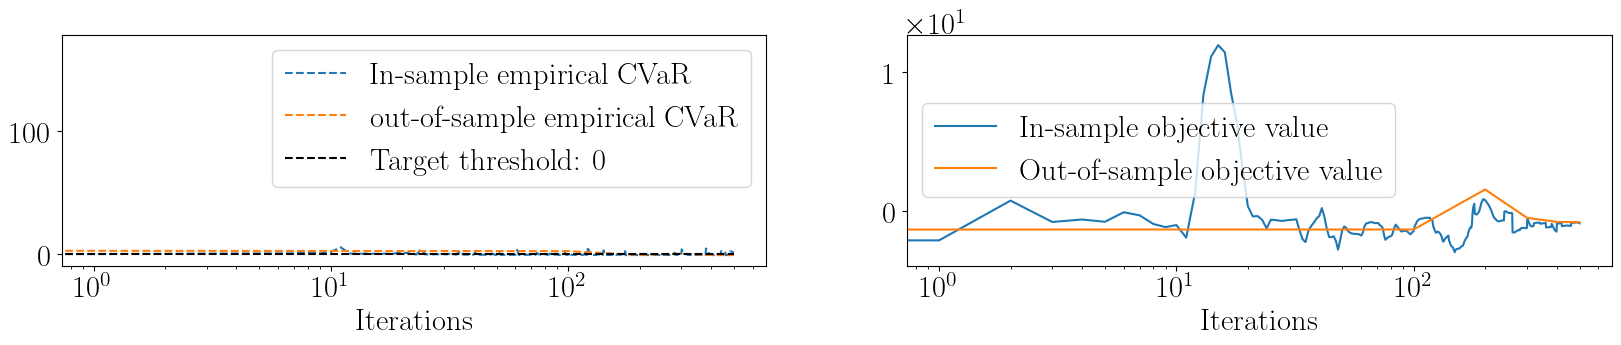

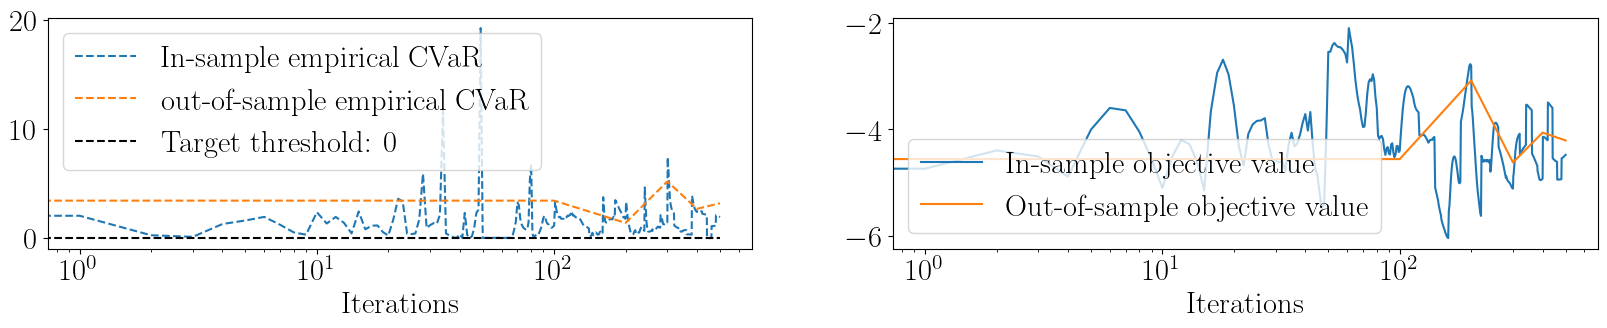

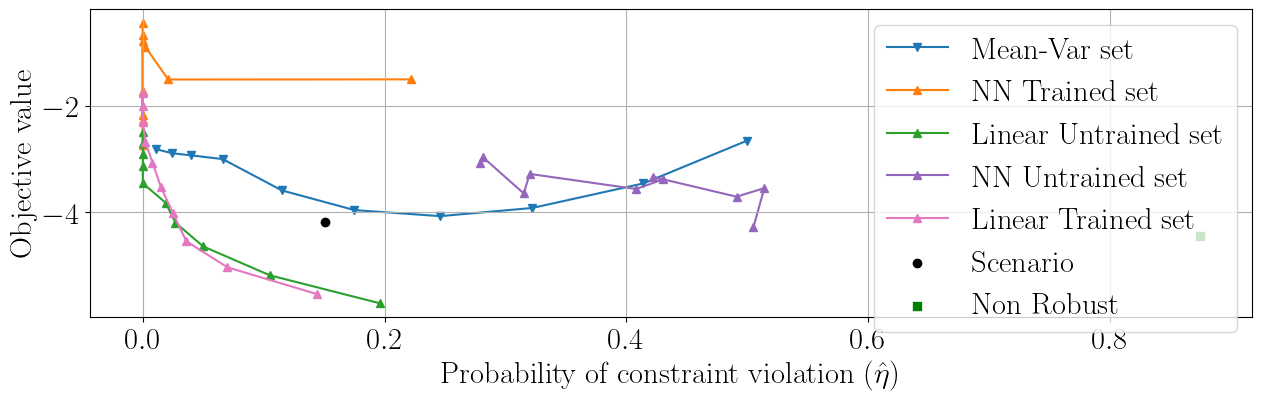

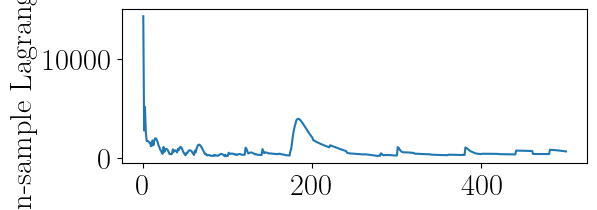

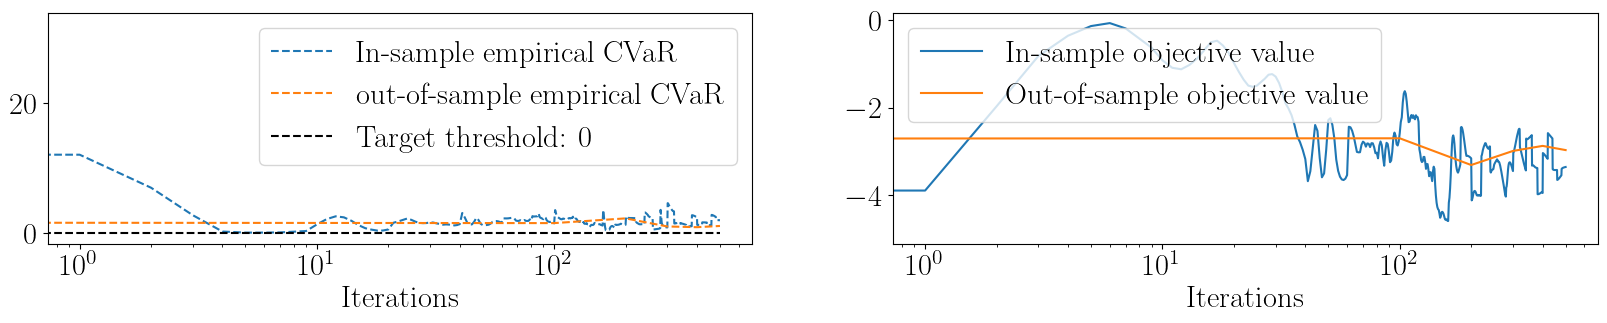

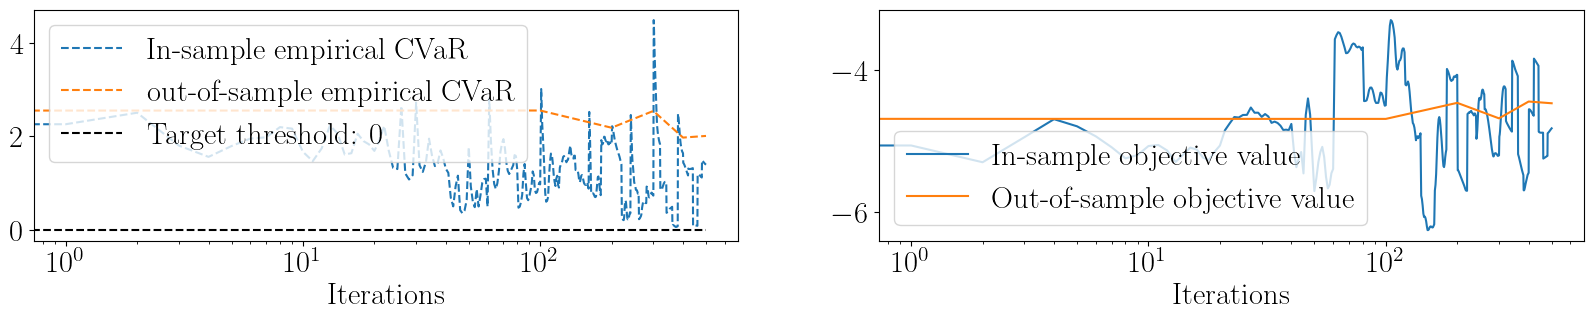

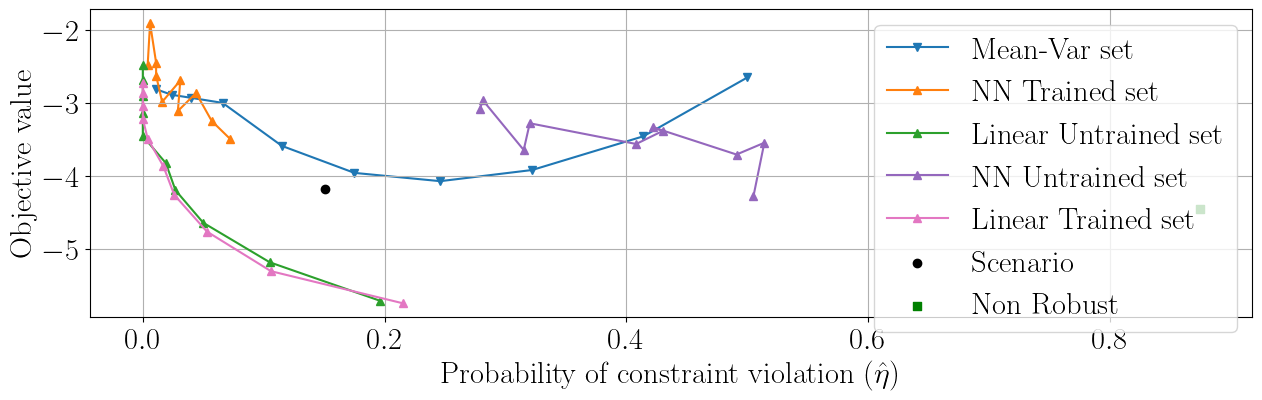

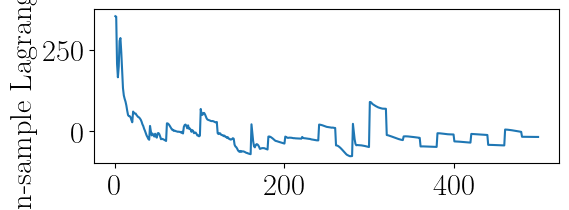

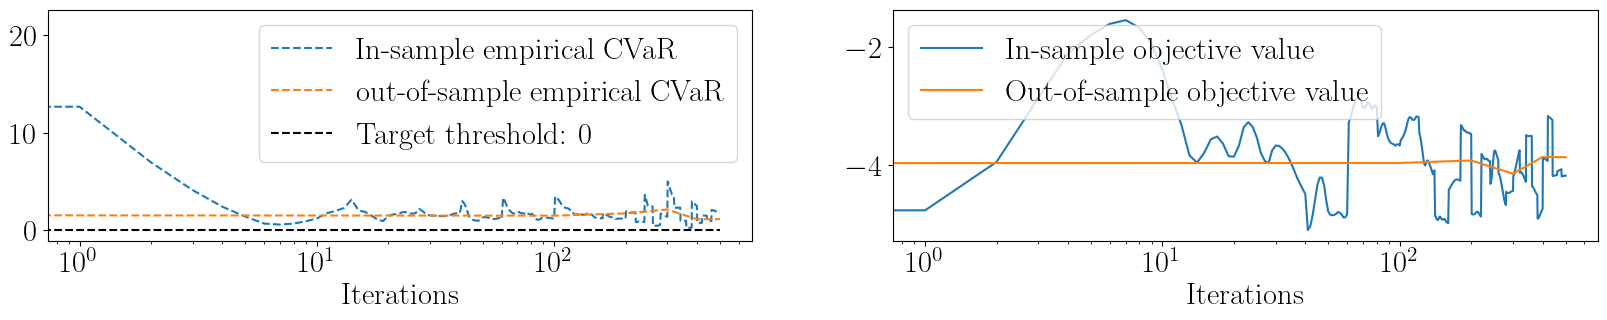

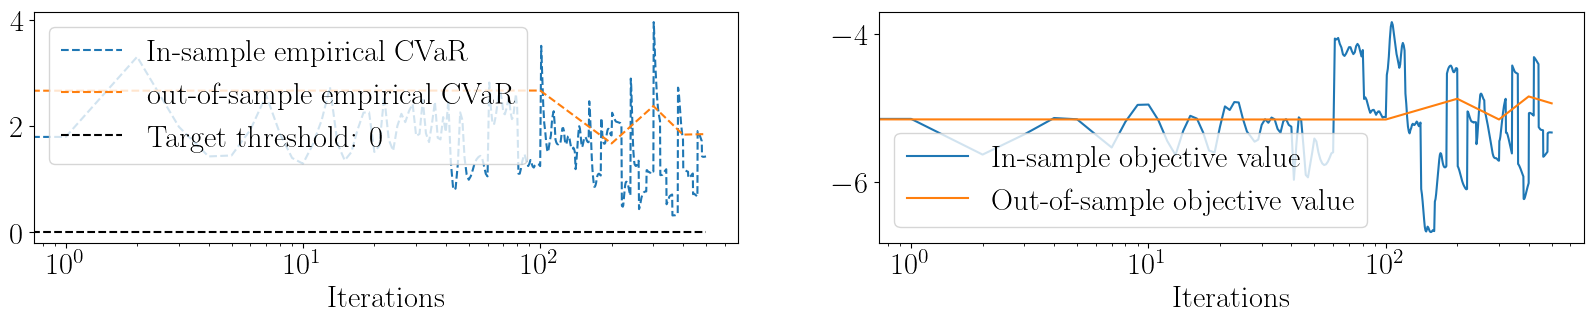

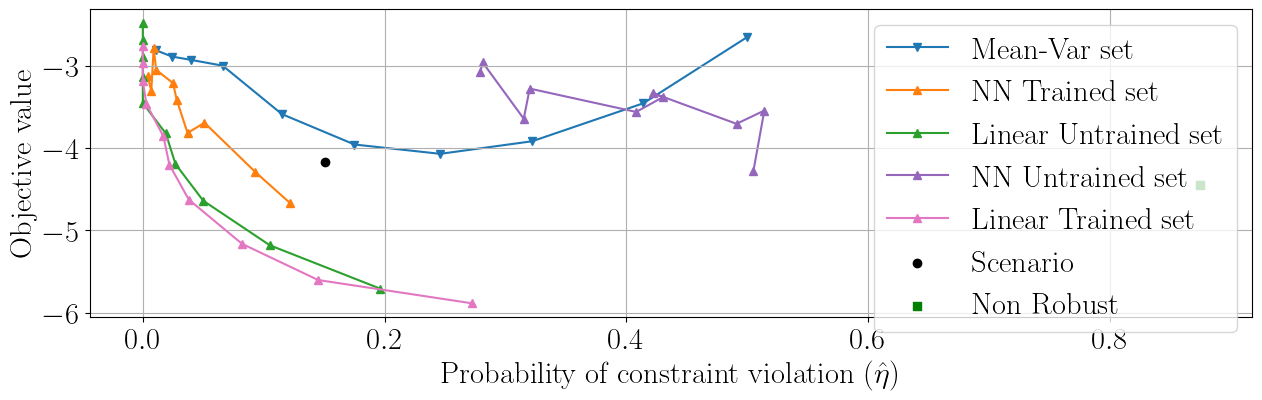

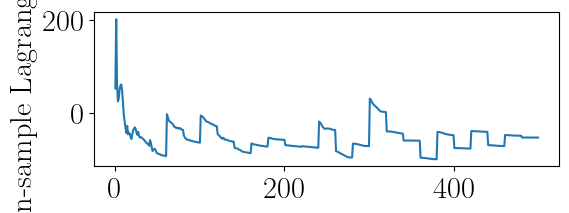

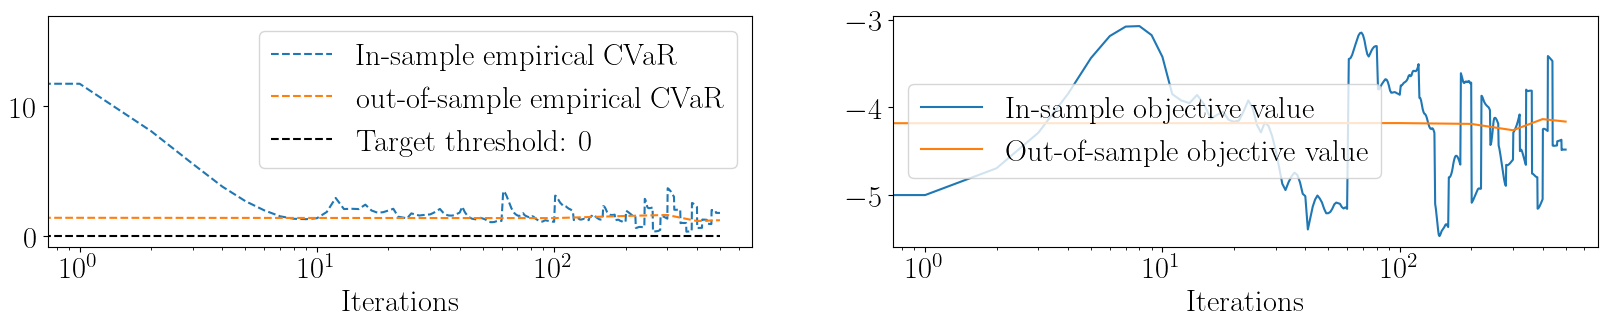

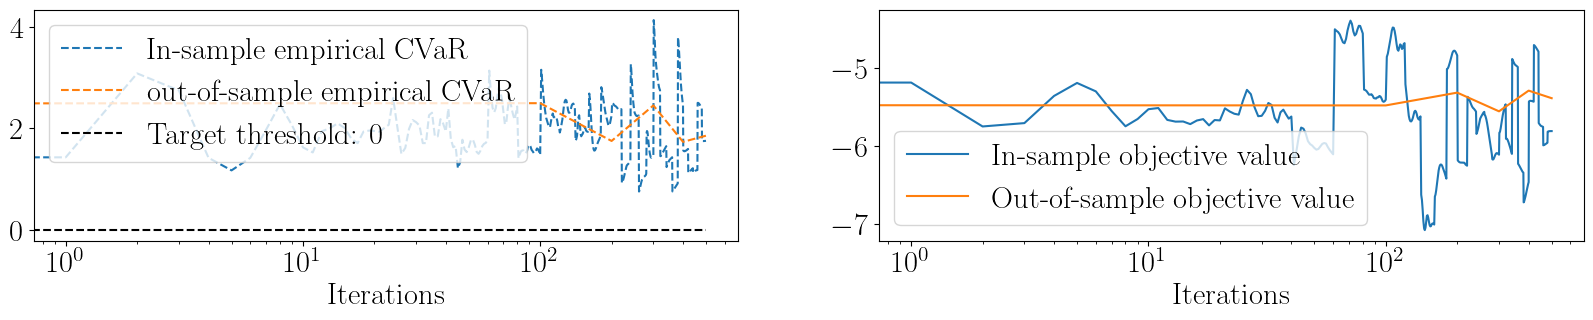

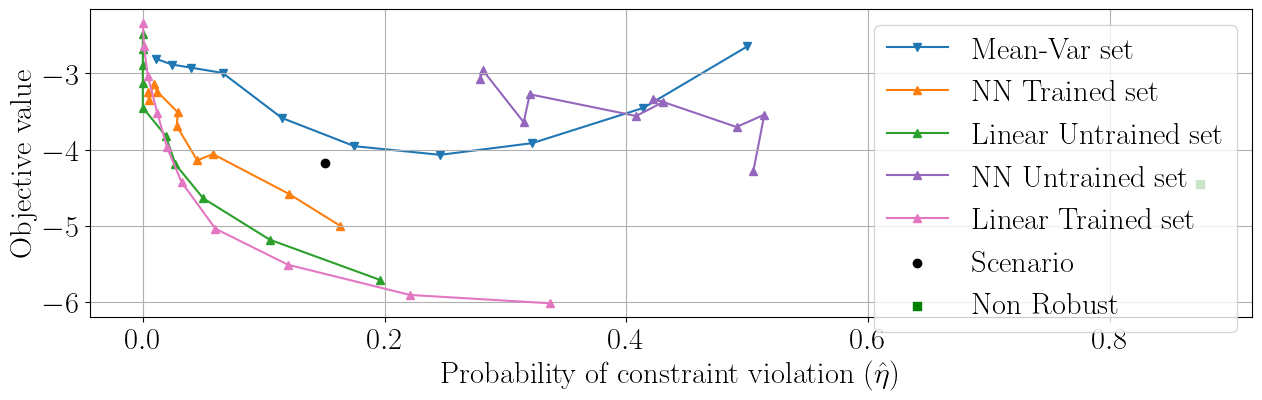

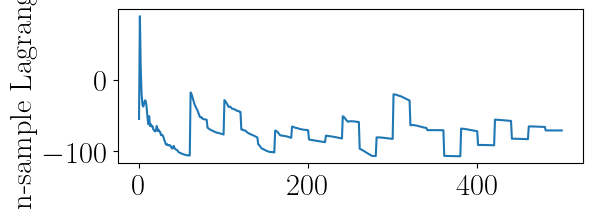

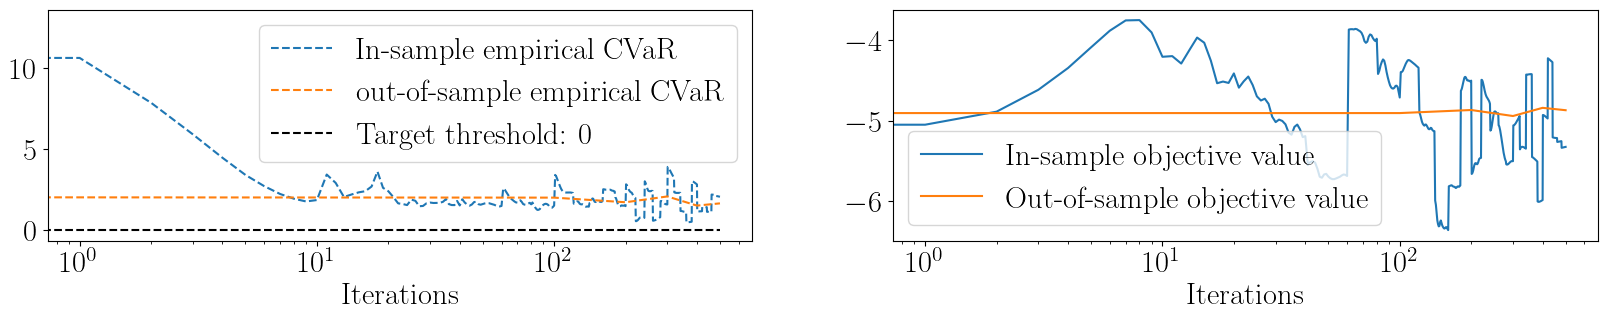

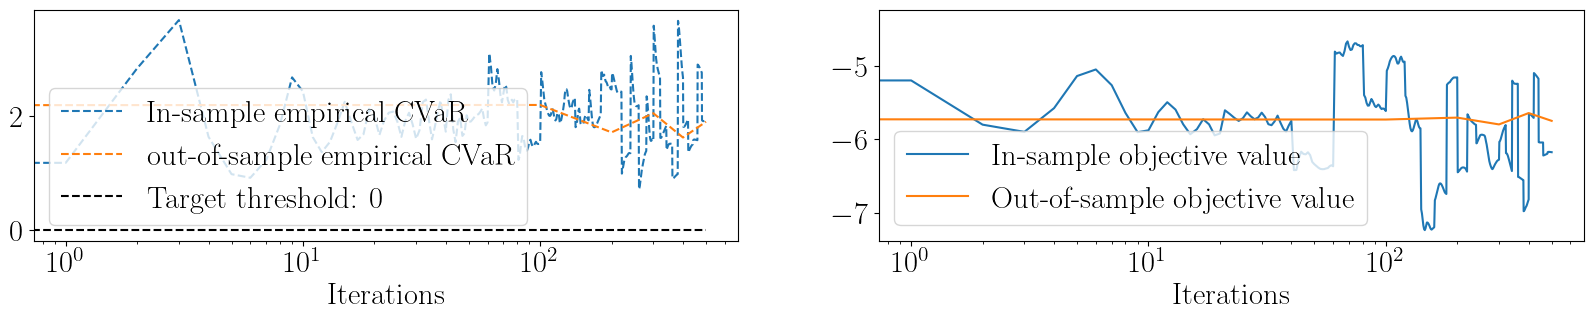

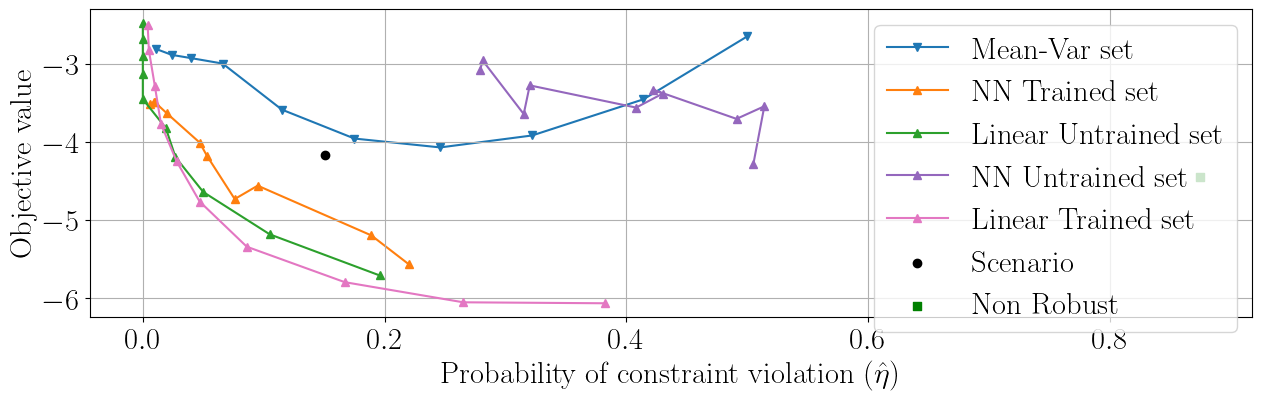

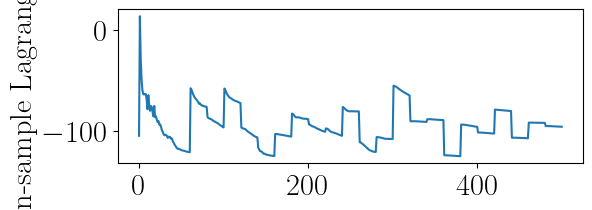

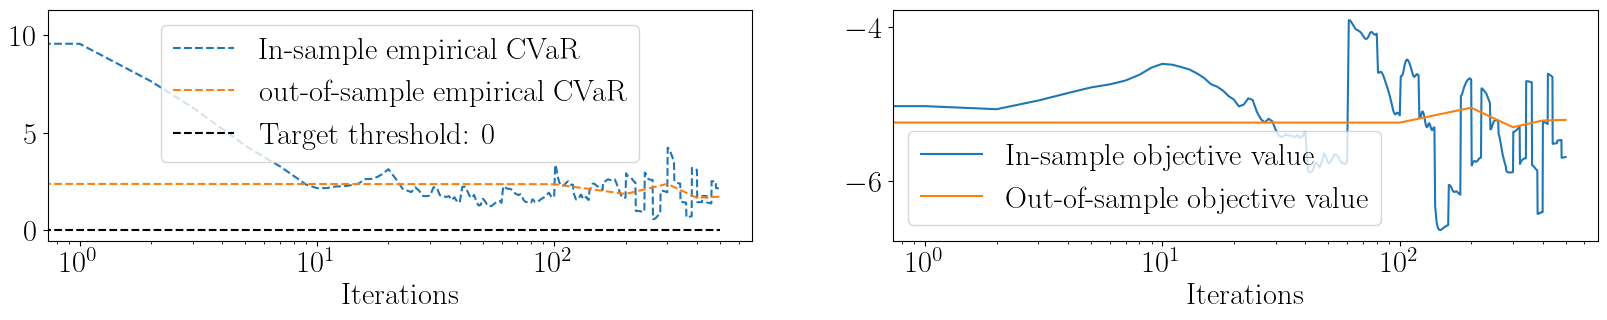

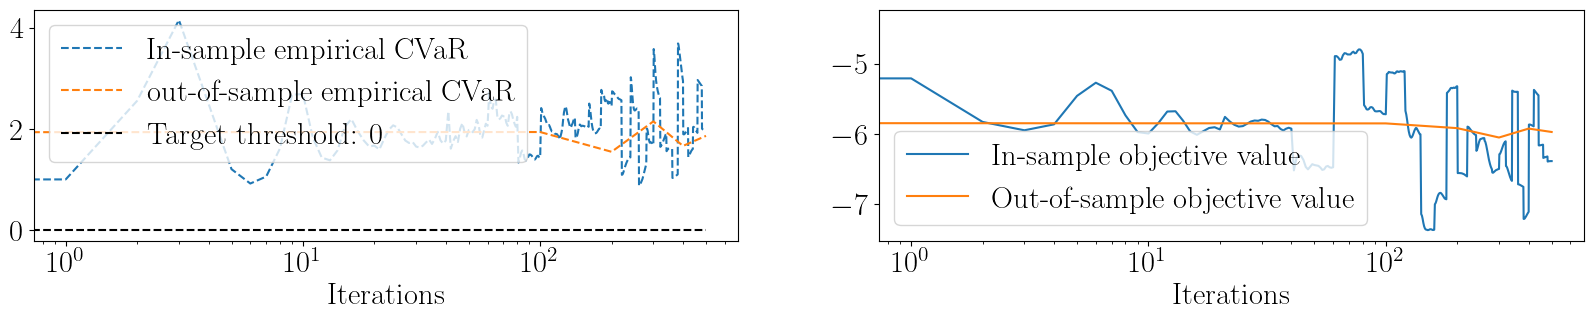

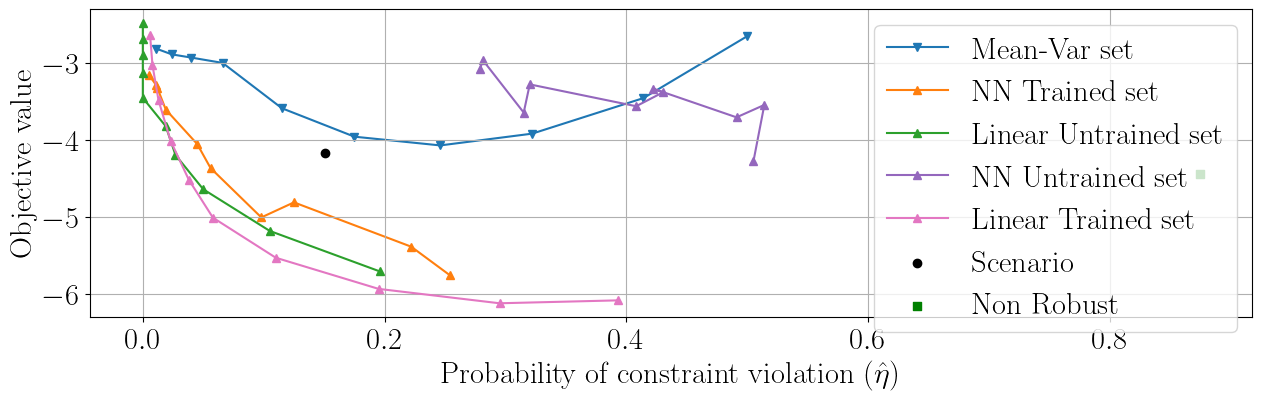

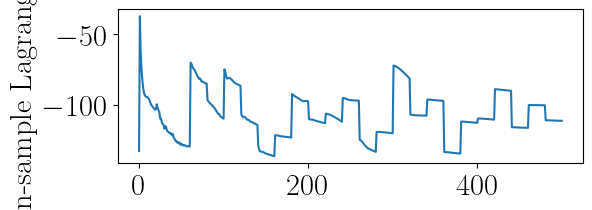

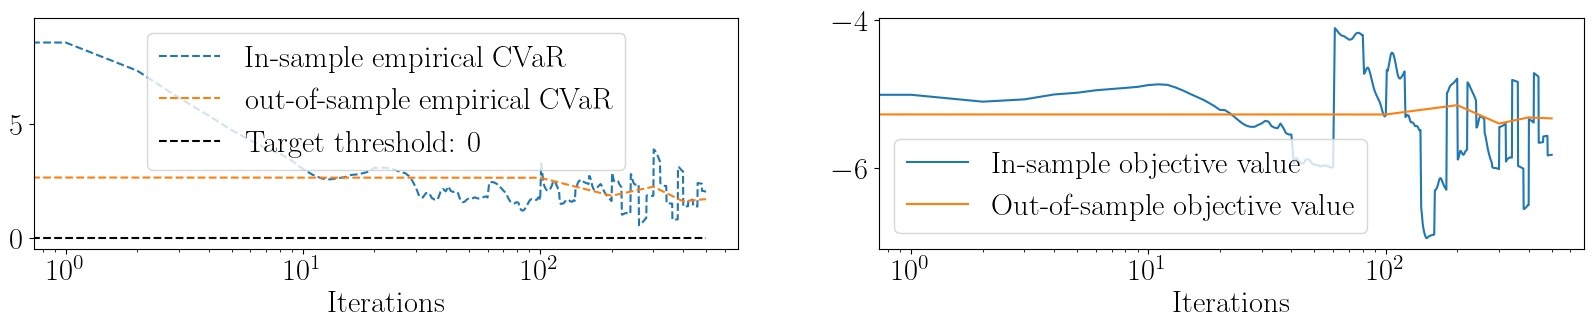

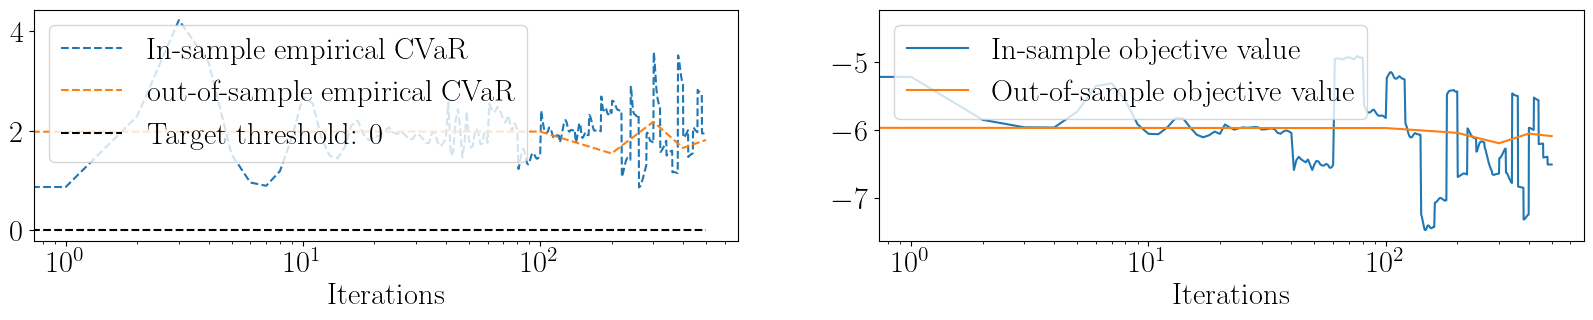

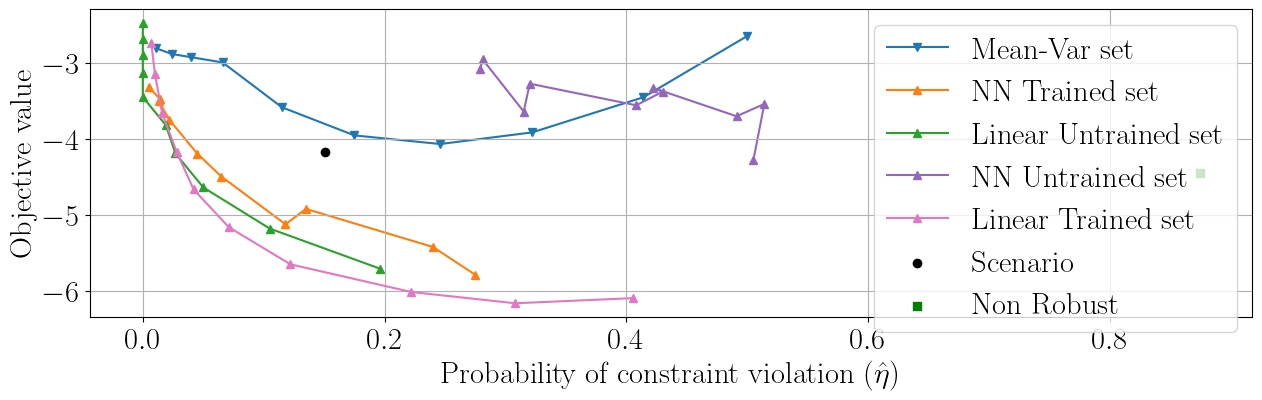

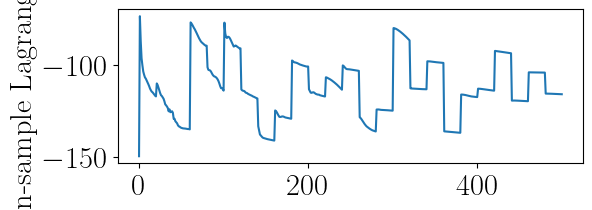

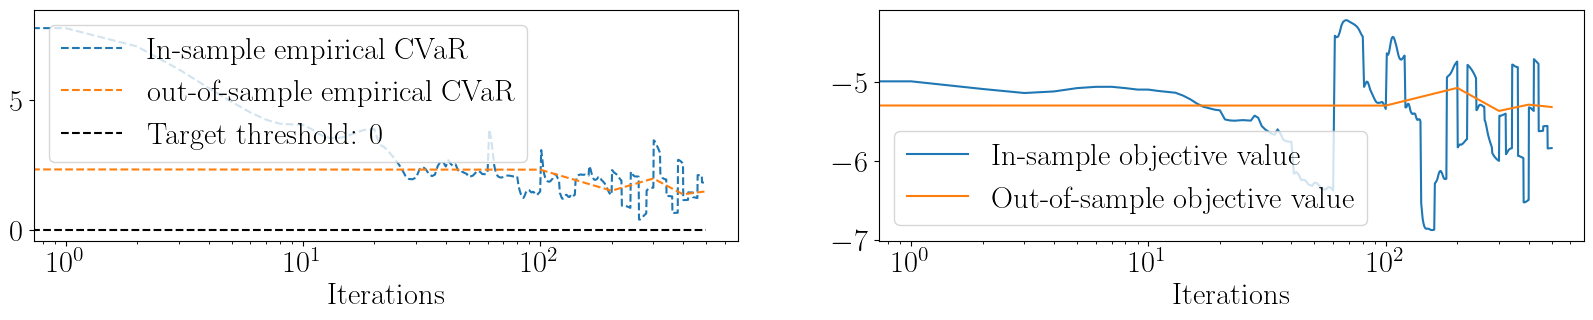

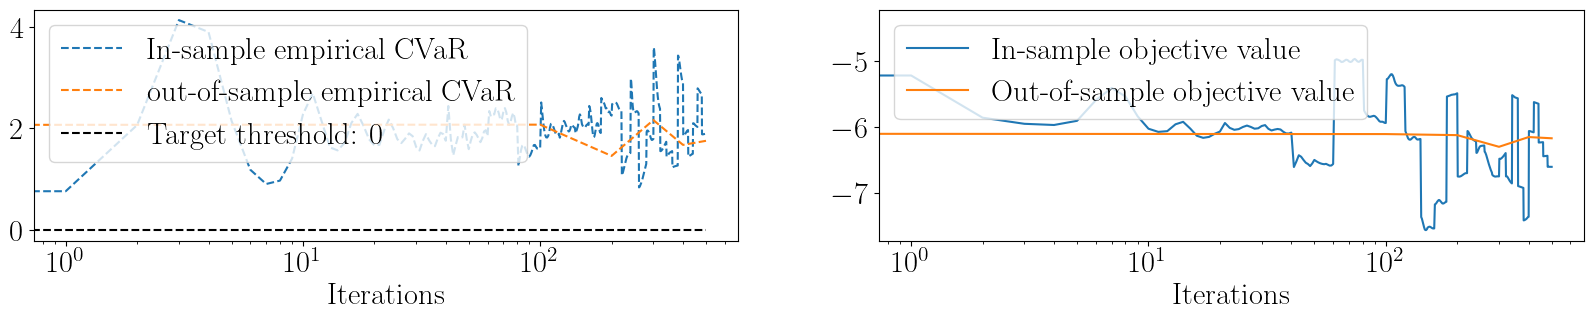

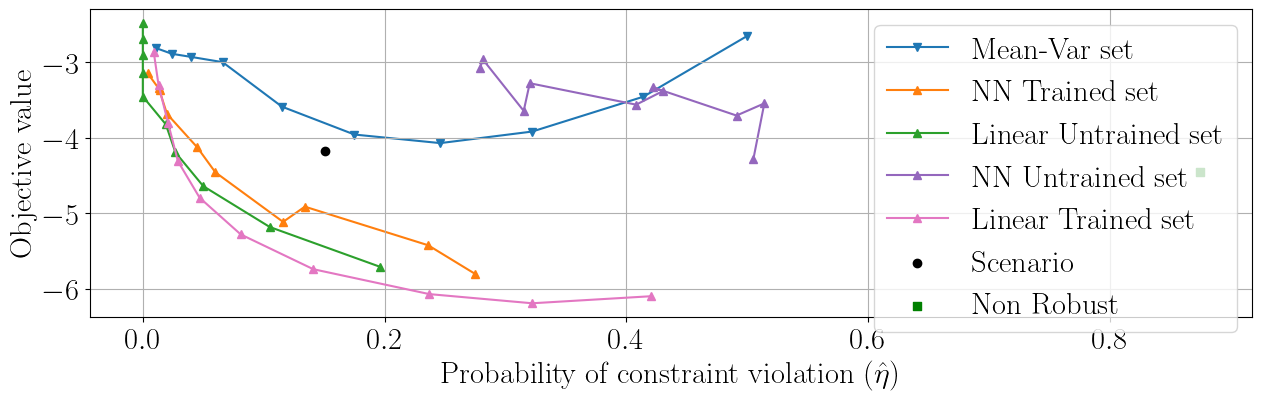

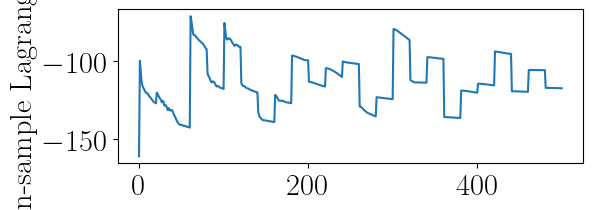

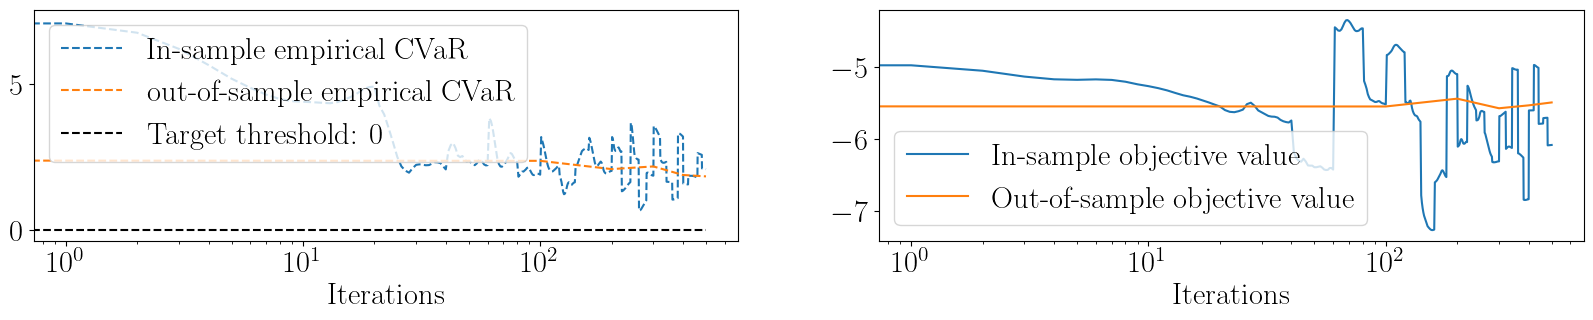

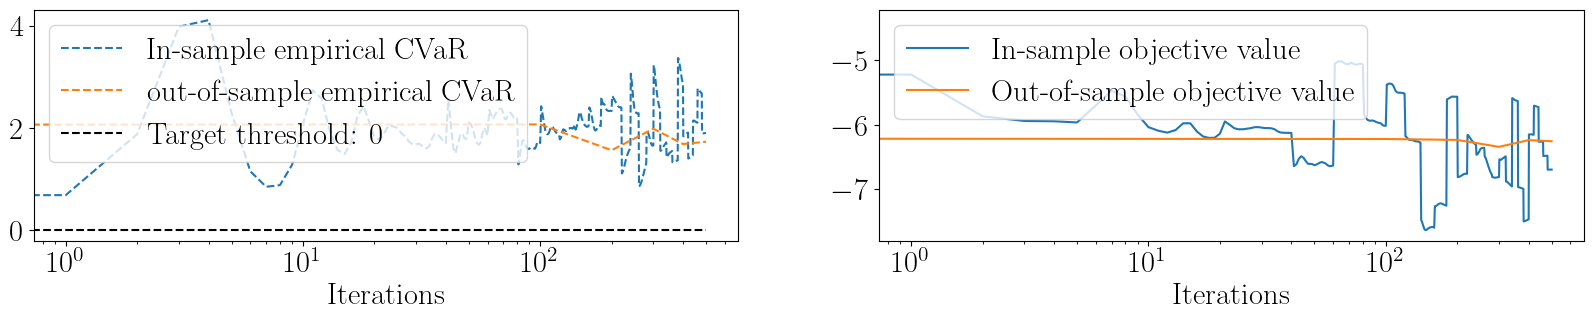

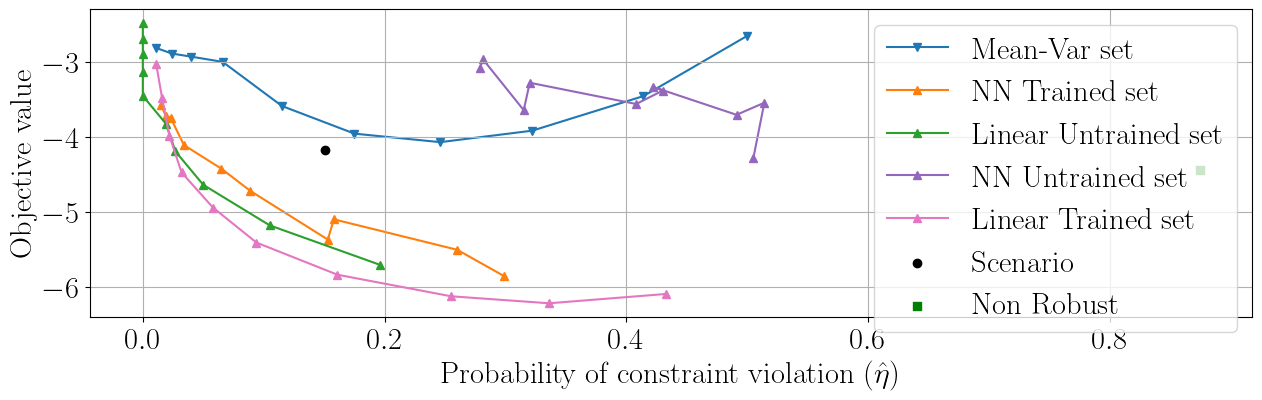

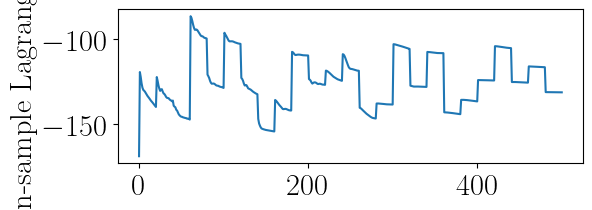

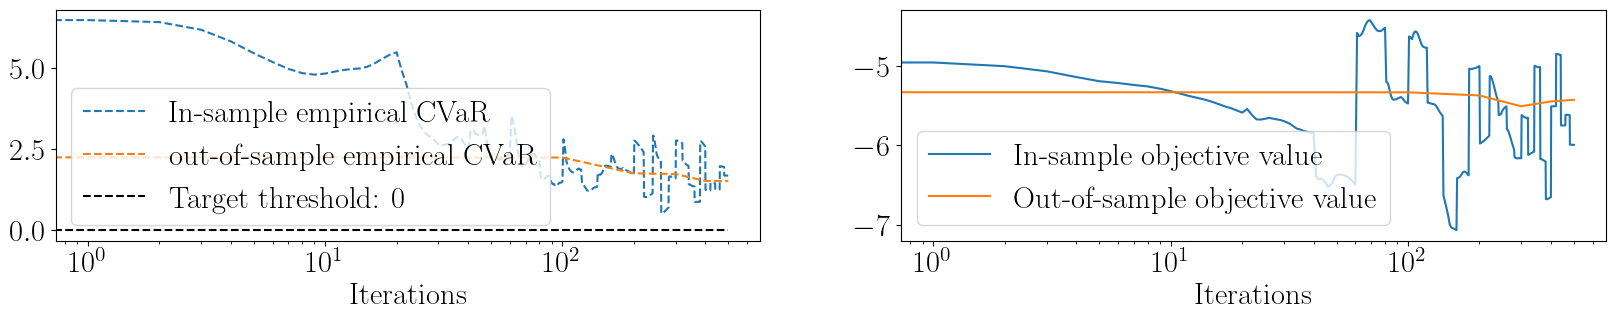

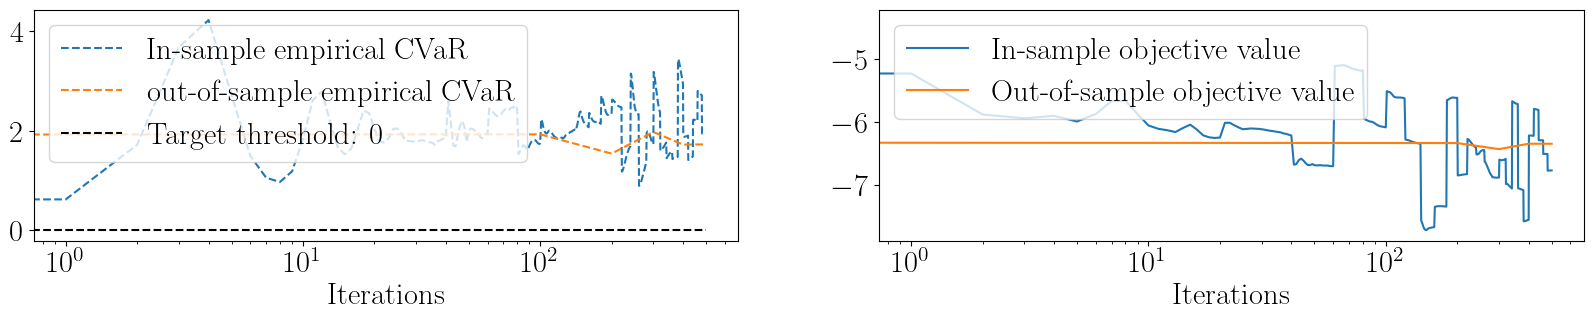

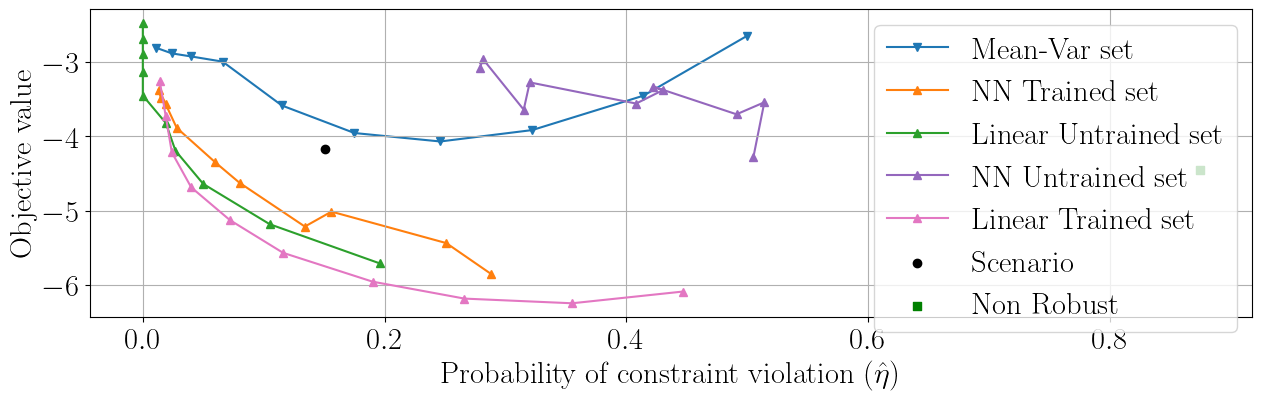

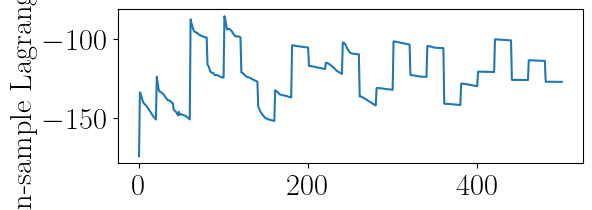

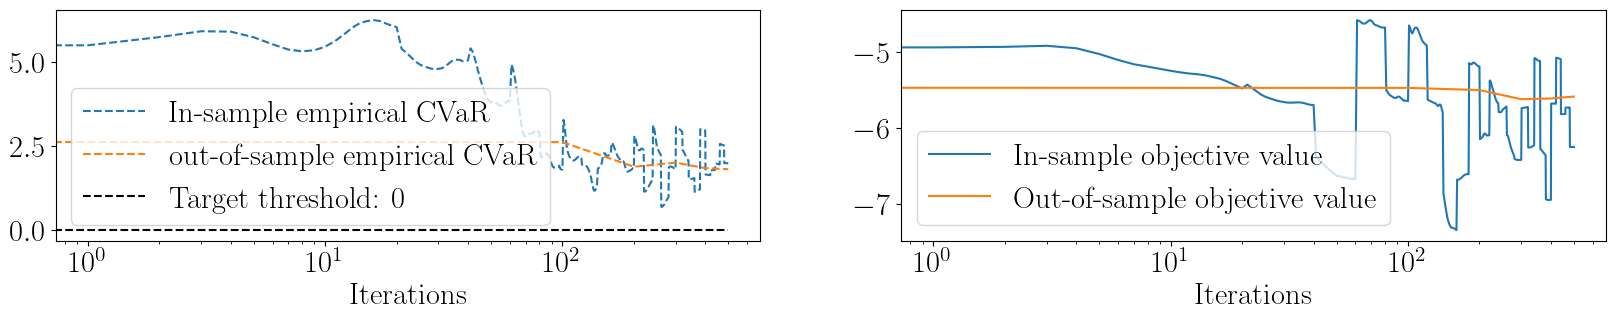

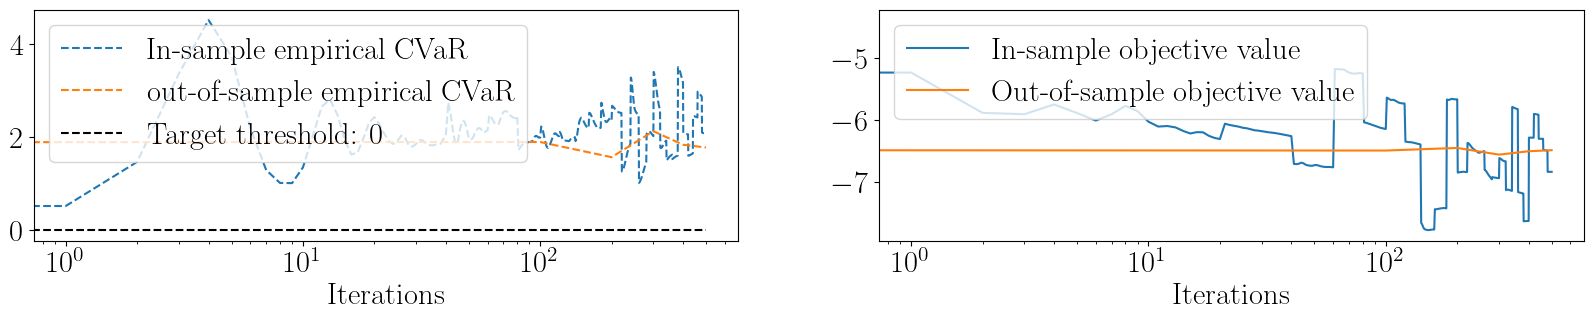

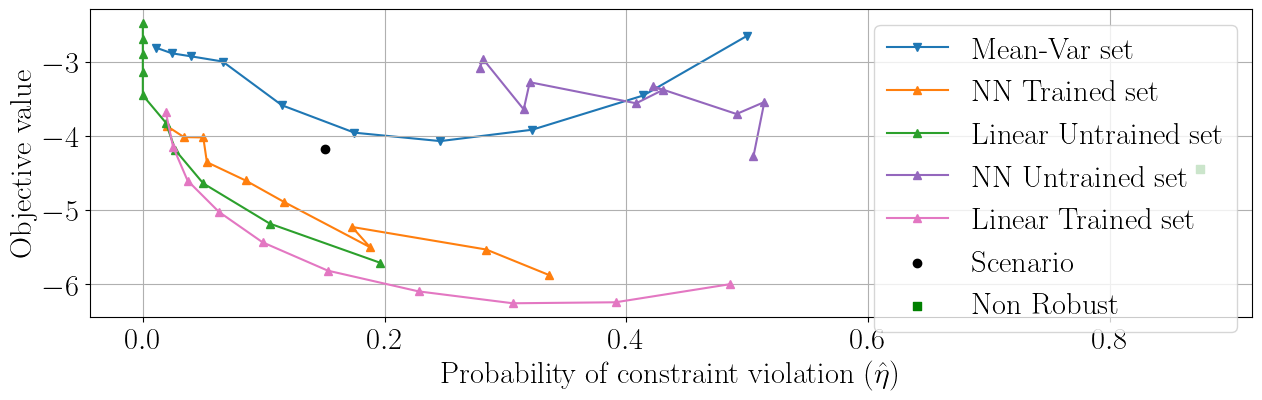

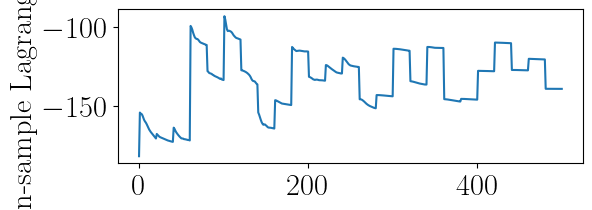

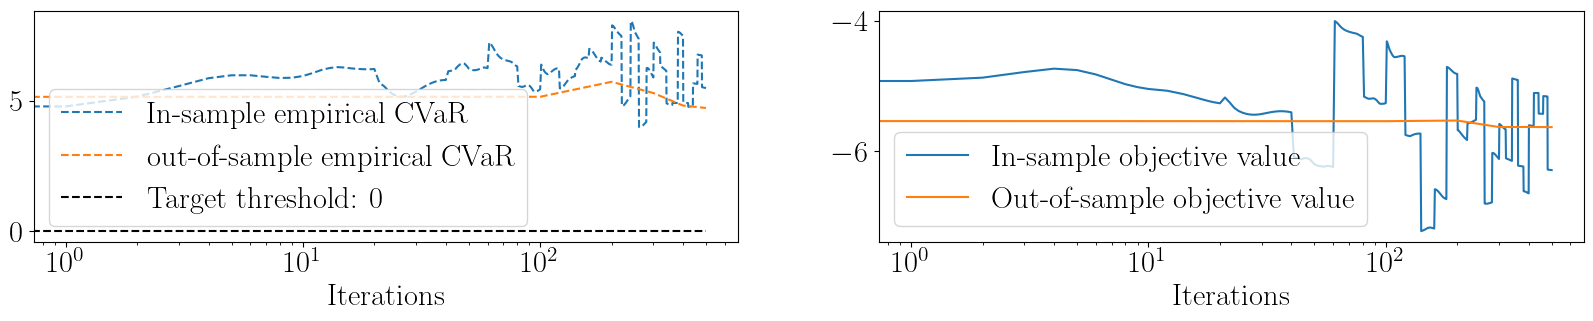

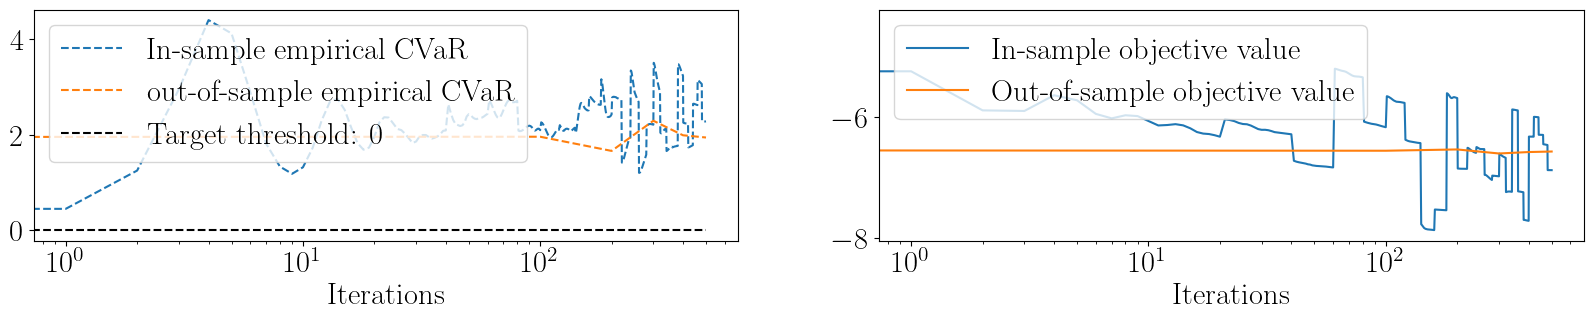

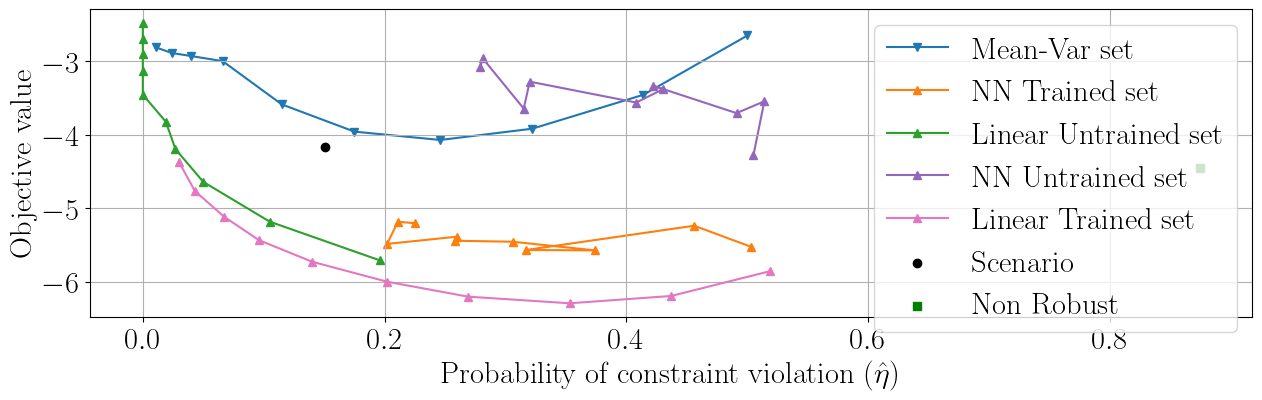

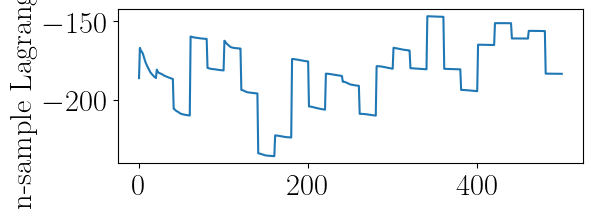

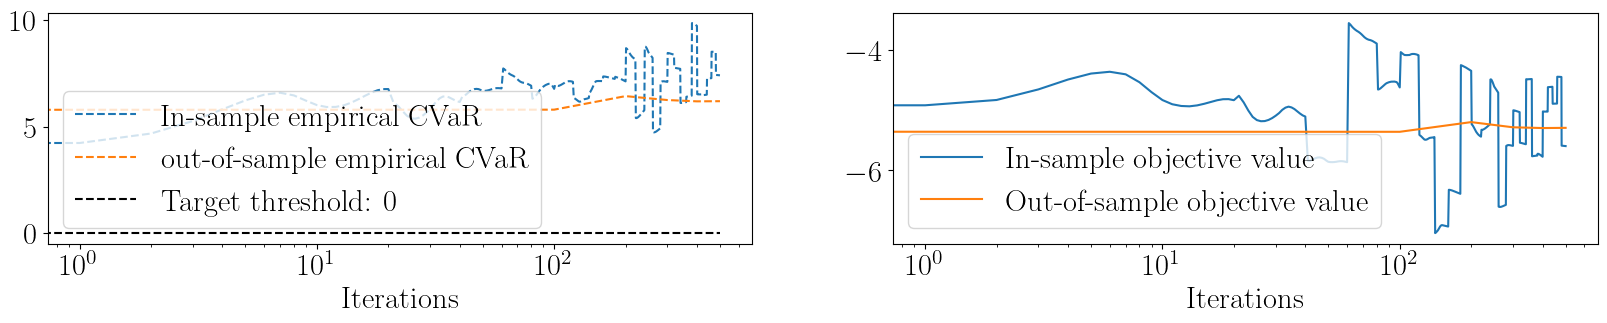

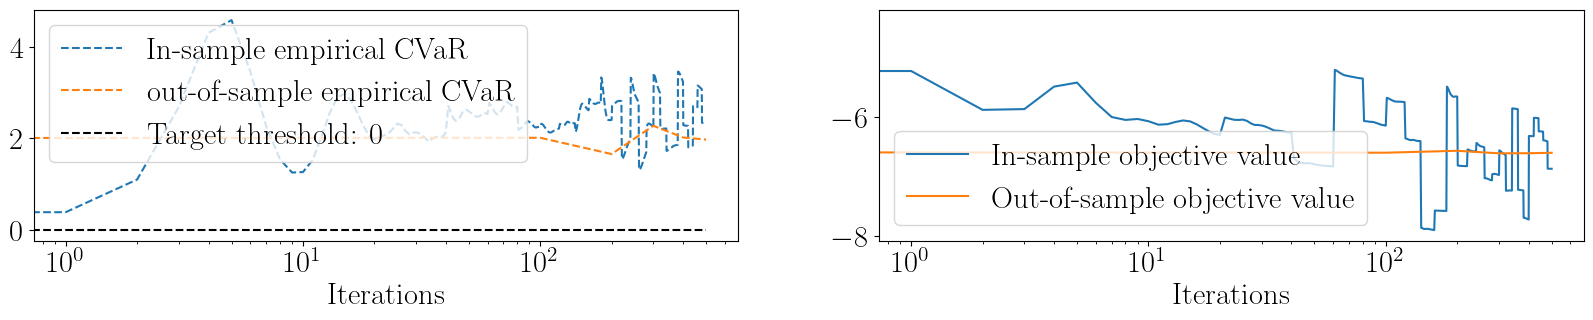

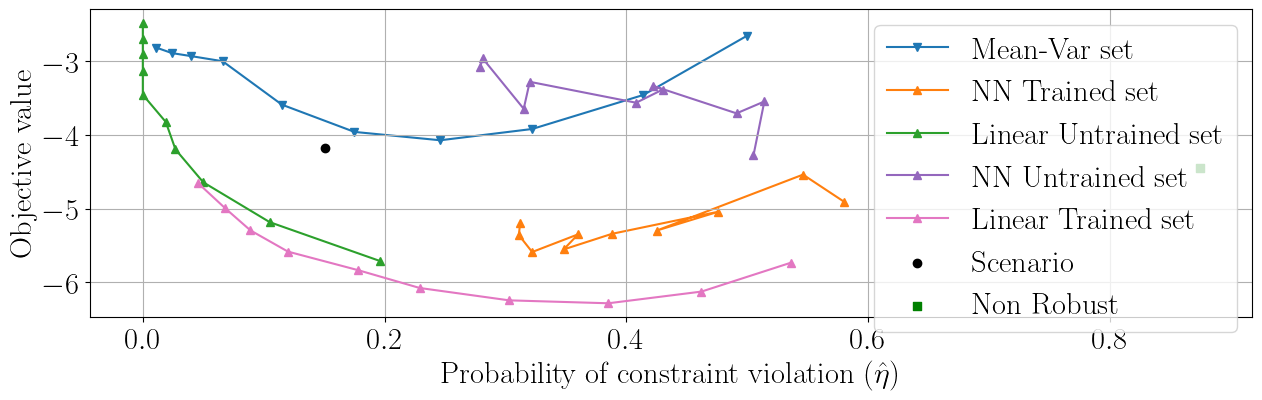

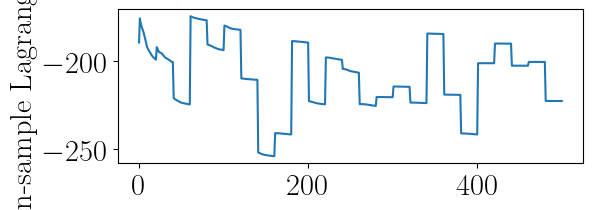

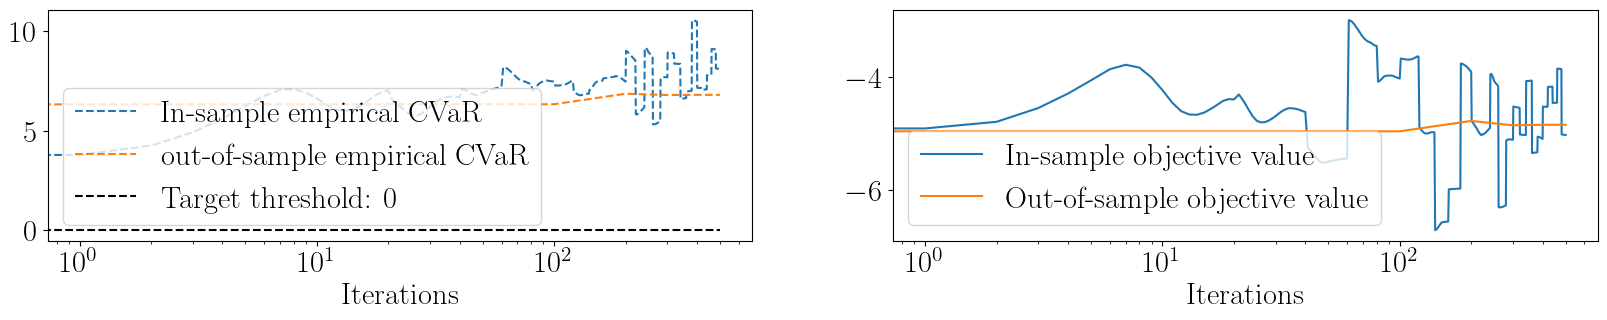

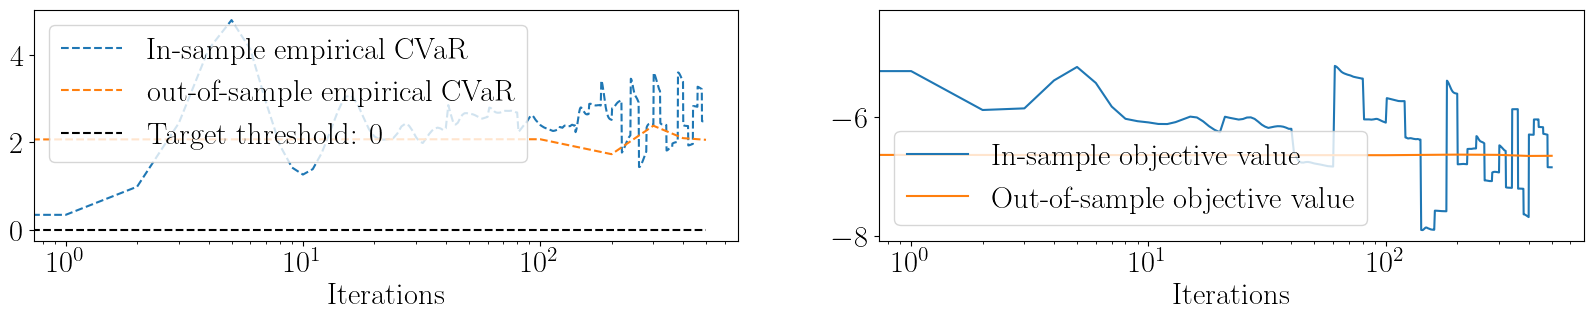

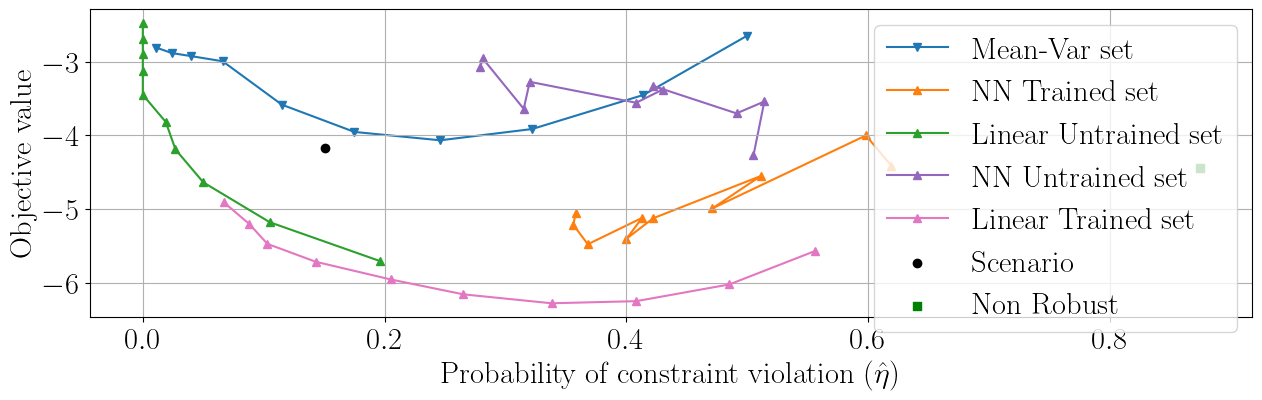

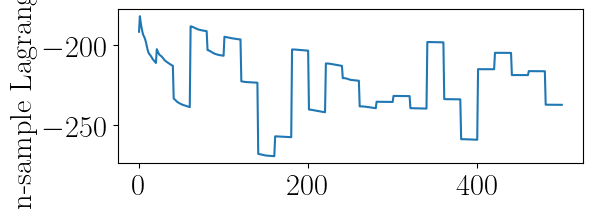

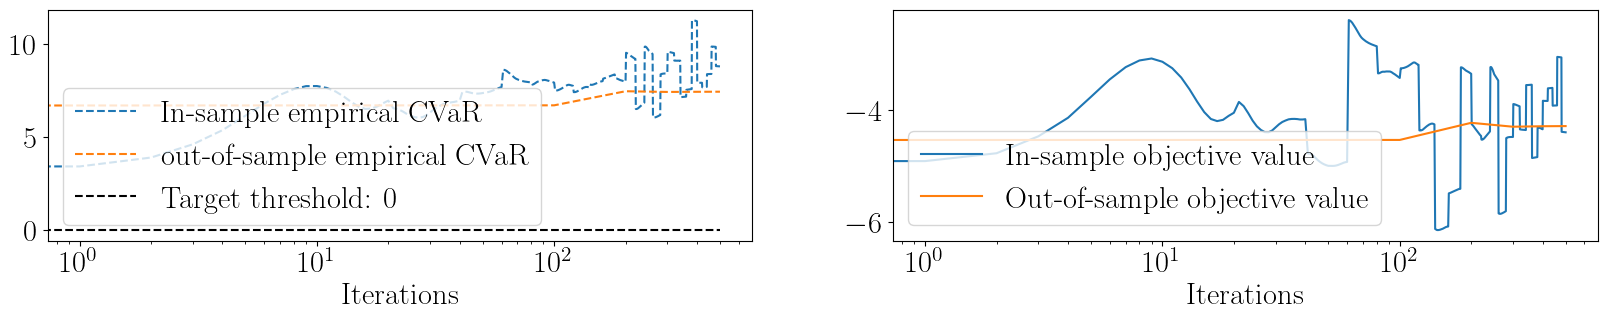

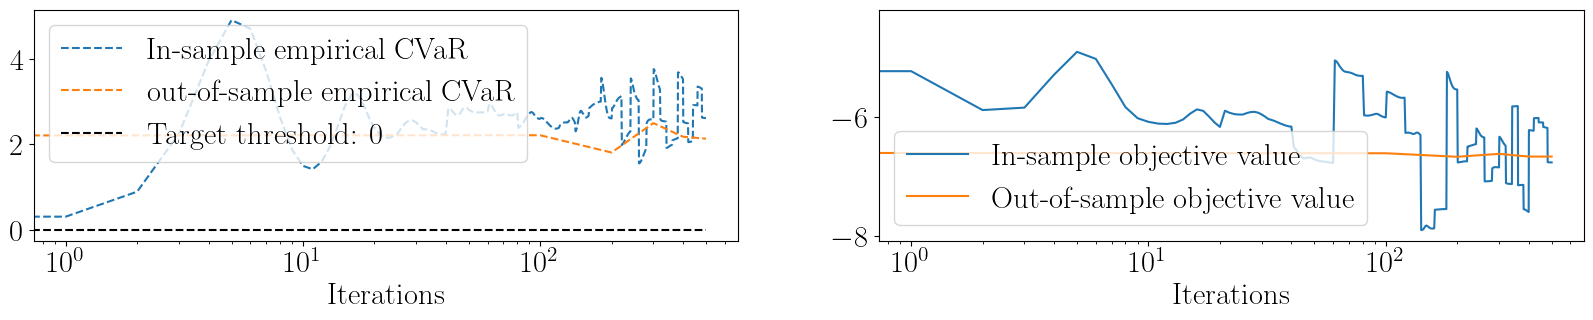

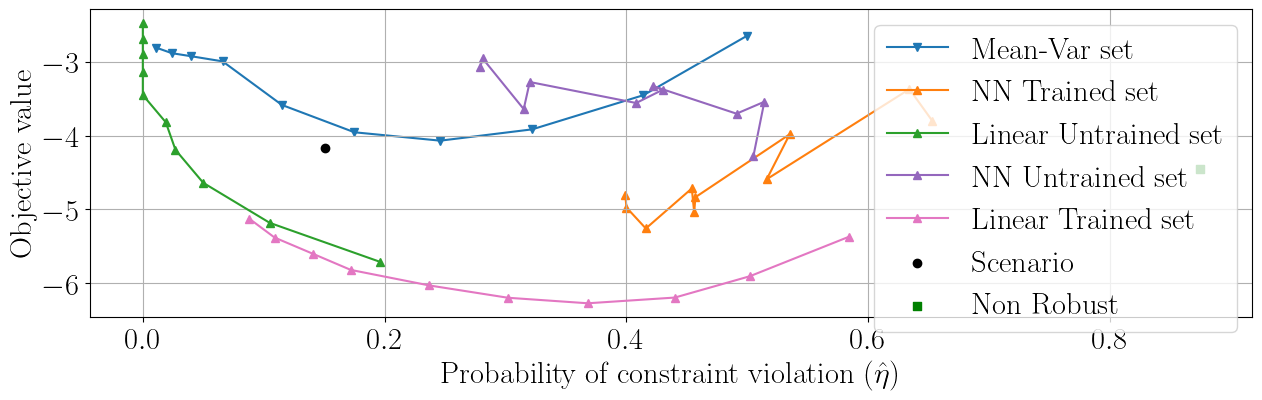

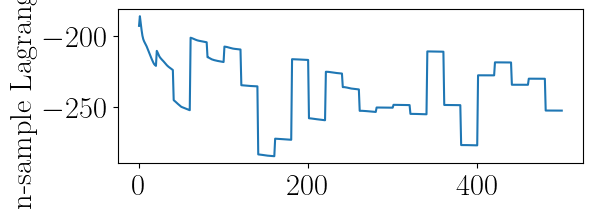

In [ ]:
etaval = [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.60,0.70,0.80,0.90,1.00]
trainvals = []
probvals = []
predictors_NN = []
rhovals_NN = []
predictors_linear = []
rhovals_linear = []
predictors_untrained_linear = []
rhovals_untrained_linear = []
predictors_untrained_NN = []
rhovals_untrained_NN = []
for exp in range(len(etaval)):
    eta = etaval[exp]
    num_iters = 501
    initn = sc.linalg.sqrtm(np.cov(train.T))
    init_bvaln = np.mean(train, axis=0)

    # Train A and b
    from lropt import Trainer
    trainer = Trainer(prob)
    trainer_settings = lropt.TrainerSettings()
    trainer_settings.lr=0.0001
    trainer_settings.num_iter=num_iters  # number of training iterations 
    trainer_settings.optimizer="SGD"
    trainer_settings.seed=5
    trainer_settings.init_A=initn
    trainer_settings.init_b=init_bvaln
    trainer_settings.init_rho = 1
    trainer_settings.init_lam= 1
    trainer_settings.init_mu= 1
    trainer_settings.mu_multiplier=1.001
    trainer_settings.test_percentage = test_p
    trainer_settings.save_history = True
    trainer_settings.lr_step_size = 50  # scheduler - every 50 steps, multiply by lr_gamma
    trainer_settings.lr_gamma = 0.5
    trainer_settings.random_init = False  # if true, initializes at random sets
    trainer_settings.num_random_init = 5
    trainer_settings.parallel = False
    trainer_settings.eta= eta
    trainer_settings.kappa = 0
    trainer_settings.contextual = True
    trainer_settings.obj_scale = 25
    trainer_settings.max_iter_line_search = 200
    trainer_settings.line_search = True
    trainer_settings.predictor = lropt.NNPredictor(predict_mean = True,pretrain = True,epochs = 500,lr = 0.001)
    trainer_settings.max_batch_size = 200
    trainer_settings.batch_percentage = 0.2
    trainer_settings.validate_percentage = valid_p
    trainer_settings.test_frequency = 600
    trainer_settings.validate_frequency = 100
    trainer_settings.initialize_predictor = True
    # trainer_settings.init_weight = init_weight  # initialization with ltsq pred
    # trainer_settings.init_bias = init_bias
    result = trainer.train(settings=trainer_settings)
    df = result.df
    result.df.to_csv('linear_training.csv')
    result.df_validate.to_csv('linear_testing.csv')
    A_fin = result.A
    b_fin = result.b

    # trained linear NN
    result_grid2 = trainer.grid(rholst=result.rho*eps_list/trainer_settings.init_rho,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result._predictor)
    dfgrid2 = result_grid2.df
    dfgrid2.to_csv('linear_trained_grid.csv')
    predictors_NN.append(result._predictor)
    rhovals_NN.append(result.rho)

    if exp ==0:
        # no training (steps = 1, look at initalized set)
        trainer_settings.predictor = lropt.LinearPredictor(predict_mean = True)
        trainer_settings.num_iter = 1 
        trainer_settings.init_rho = 1
        result2 = trainer.train(settings=trainer_settings)
        df2 = result2.df
        A_fin2 = result2.A
        b_fin2 = result2.b
        predictors_untrained_linear.append(result2._predictor)
        rhovals_untrained_linear.append(result2.rho)

        # untrained linear
        result_grid3 = trainer.grid(rholst=eps_list,init_A=A_fin2, init_b=b_fin2, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result2._predictor)
        dfgrid3 = result_grid3.df
        dfgrid3.to_csv('linear_untrained_grid.csv')

    # untrained NN
        trainer_settings.predictor = lropt.NNPredictor(predict_mean = True,pretrain = True,epochs = 500,lr = 0.001)
        trainer_settings.num_iter = 1 
        trainer_settings.init_rho = 1
        result3 = trainer.train(settings=trainer_settings)
        df3 = result3.df
        A_fin3 = result3.A
        b_fin3 = result3.b
        predictors_untrained_NN.append(result3._predictor)
        rhovals_untrained_NN.append(result3.rho)

        result_grid4 = trainer.grid(rholst=eps_list,init_A=A_fin3, init_b=b_fin3, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result3._predictor)
        dfgrid4 = result_grid4.df

    # trained linear
    trainer_settings.predictor = lropt.LinearPredictor(predict_mean = True,pretrain = True,epochs = 100, lr = 0.001)
    trainer_settings.num_iter = num_iters
    trainer_settings.init_rho = 1
    trainer_settings.obj_scale = 5
    result4 = trainer.train(settings=trainer_settings)
    df4 = result4.df
    A_fin4 = result4.A
    b_fin4 = result4.b
    predictors_linear.append(result4._predictor)
    rhovals_linear.append(result4.rho)

    result_grid5 = trainer.grid(rholst=result4.rho*eps_list,init_A=A_fin4, init_b=b_fin4, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result4._predictor)
    dfgrid5 = result_grid5.df

    def plot_iters(dftrain,dftest, title, steps=2000, logscale=True,kappa=0):
        plt.rcParams.update({
            "text.usetex": True,

            "font.size": 22,
            "font.family": "serif"
        })
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

        # ax1.plot(dftrain["Violation_val"][:steps],
        #          label="Out-of-sample empirical CVaR")
        ax1.plot(dftrain["Violations_train"][:steps],
                label="In-sample empirical CVaR", linestyle="--")
        ax1.plot(np.arange(0,num_iters, trainer_settings.validate_frequency),dftest["Violations_validate"][:steps],
                label="out-of-sample empirical CVaR", linestyle="--")

        ax1.set_xlabel("Iterations")
        ax1.hlines(xmin=0, xmax=dftrain["Violations_train"][:steps].shape[0],
                y=kappa, linestyles="--", color="black", label=f"Target threshold: {kappa}")
        ax1.legend()
        ax2.plot(dftrain["Train_val"][:steps], label="In-sample objective value")
        ax2.plot(np.arange(0,num_iters, trainer_settings.validate_frequency),dftest["Validate_val"][:steps], label="Out-of-sample objective value")

        ax2.set_xlabel("Iterations")
        ax2.ticklabel_format(style="sci", axis='y',
                            scilimits=(0, 0), useMathText=True)
        ax2.legend()
        if logscale:
            ax1.set_xscale("log")
            ax2.set_xscale("log")
        plt.savefig(title+"_iters.pdf", bbox_inches='tight')

    # training with linear NN - erratic balues
    plot_iters(result.df,result.df_validate, steps=num_iters, title="training_"+str(eta),kappa=trainer_settings.kappa)
    plot_iters(result4.df,result4.df_validate, steps=num_iters, title="training_linear"+str(eta),kappa=trainer_settings.kappa)

    # Grid search epsilon
    # mean variance set
    result_grid = trainer.grid(rholst=eps_list, init_A=initn,
                        init_b=init_bvaln, seed=s,
                        init_alpha=0., test_percentage=test_p, quantiles = (0.3, 0.7))
    dfgrid = result_grid.df
    dfgrid.to_csv('mean_var_grid.csv')

    epslst =eps_list
    prob_list = np.array([0.,0.01,0.05,0.1])
    inds_standard = []
    inds_reshaped = []
    inds_untrained = []
    for i in prob_list:
        inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
        inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())
        inds_untrained.append(np.absolute(np.mean(np.vstack(dfgrid3['Avg_prob_test']),axis = 1)-i).argmin())
    
    beg1, end1 = 0, 100
    beg2, end2 = 0, 100
    plt.figure(figsize=(15, 4))
    plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
        dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
    plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
        dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="NN Trained set", marker="^", zorder=1)
    plt.plot(np.mean(np.vstack(dfgrid3['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
        dfgrid3['Test_val']), axis=1)[beg2:end2], color="tab:green", label="Linear Untrained set", marker="^", zorder=2)
    plt.plot(np.mean(np.vstack(dfgrid4['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
        dfgrid4['Test_val']), axis=1)[beg2:end2], color="tab:purple", label="NN Untrained set", marker="^", zorder=1)
    plt.plot(np.mean(np.vstack(dfgrid5['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
        dfgrid5['Test_val']), axis=1)[beg2:end2], color="tab:pink", label="Linear Trained set", marker="^", zorder=2)

    plt.ylabel("Objective value")
    plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
    # plt.ylim([-9, 0])
    plt.grid()
    plt.scatter(context_probs,context_evals, color = "black", label="Scenario")
    plt.scatter(nonrob_probs,nonrob_evals, color = "green", marker = "s", label="Non Robust")
    plt.legend()
    plt.savefig("news_objective_vs_violations_"+str(eta)+".pdf", bbox_inches='tight')

    plt.figure(figsize=(6,2))
    plt.plot(df["Lagrangian_val"])
    plt.ylabel("In-sample Lagrangian")
    plt.savefig("Lagrangian_"+str(eta)+".pdf", bbox_inches='tight')

    trainvals.append(dfgrid2["Test_val"][3])
    probvals.append(dfgrid2["Avg_prob_test"][3])
    print(trainvals, probvals)

In [15]:
torch.save(predictors_NN[0].state_dict(),'my_model.pth')
predictors_NN[0].load_state_dict(torch.load('my_model.pth'))

<All keys matched successfully>

In [7]:
df_valid_NN, df_test_NN = trainer.compare_predictors(settings=trainer_settings,predictors_list = predictors_NN, rho_list=rhovals_NN)
df_valid_linear, df_test_linear = trainer.compare_predictors(settings=trainer_settings,predictors_list = predictors_linear, rho_list=rhovals_linear)
df_valid_linear_untrained, df_test_linear_untrained = trainer.compare_predictors(settings=trainer_settings,predictors_list = predictors_untrained_linear, rho_list=rhovals_untrained_linear)
df_valid_NN_untrained, df_test_NN_untrained = trainer.compare_predictors(settings=trainer_settings,predictors_list = predictors_untrained_NN, rho_list=rhovals_untrained_NN)

Training:   0%|          | 0/1 [00:04<?, ?it/s]


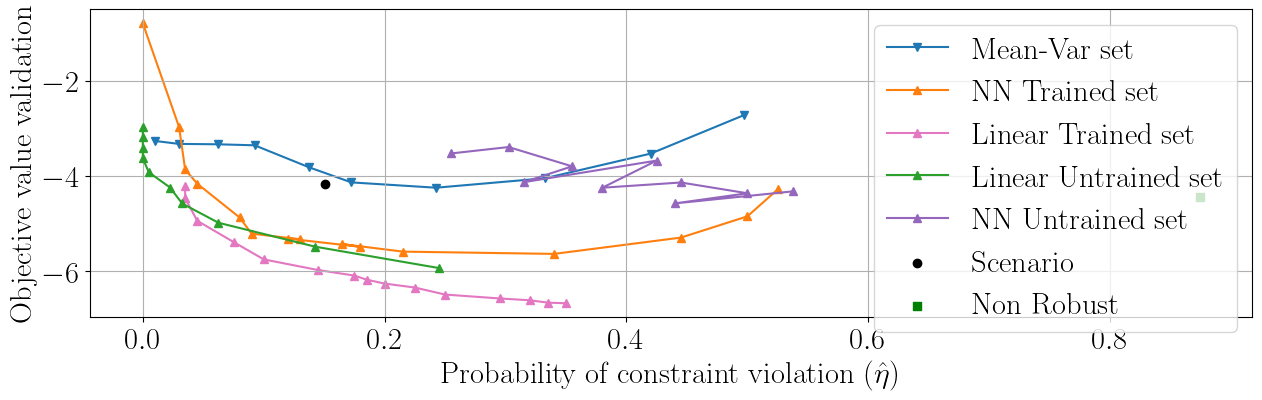

In [8]:
beg1, end1 = 0, 100
beg2, end2 = 0, 100
plt.figure(figsize=(15, 4))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_validate']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Validate_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.plot(df_valid_NN["Avg_prob_validate"],df_valid_NN["Validate_val"], color="tab:orange", label="NN Trained set", marker="^", zorder=1)
plt.plot(df_valid_linear["Avg_prob_validate"],df_valid_linear["Validate_val"], color="tab:pink", label="Linear Trained set", marker="^", zorder=1)
plt.plot(np.mean(np.vstack(dfgrid3['Avg_prob_validate']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid3['Validate_val']), axis=1)[beg2:end2], color="tab:green", label="Linear Untrained set", marker="^", zorder=2)
plt.plot(np.mean(np.vstack(dfgrid4['Avg_prob_validate']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid4['Validate_val']), axis=1)[beg2:end2], color="tab:purple", label="NN Untrained set", marker="^", zorder=2)
plt.ylabel("Objective value validation")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.ylim([-7.4, -2.6])
plt.grid()
plt.scatter(context_probs,context_evals, color = "black", label="Scenario")
plt.scatter(nonrob_probs,nonrob_evals, color = "green", marker = "s", label="Non Robust")
plt.legend()
plt.savefig("news_objective_vs_violations_comb"+".pdf", bbox_inches='tight')

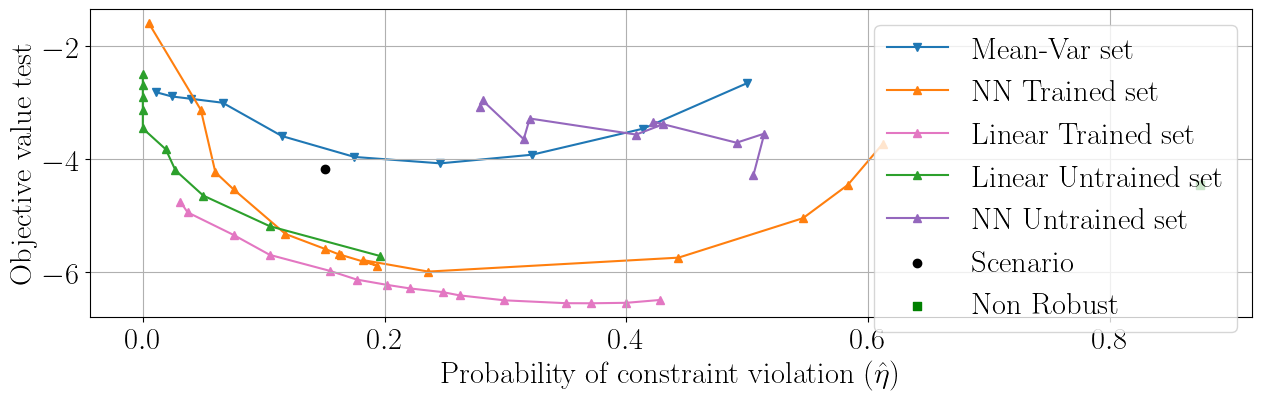

In [9]:
beg1, end1 = 0, 100
beg2, end2 = 0, 100
plt.figure(figsize=(15, 4))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.plot(df_test_NN["Avg_prob_test"],df_test_NN["Test_val"], color="tab:orange", label="NN Trained set", marker="^", zorder=1)
plt.plot(df_test_linear["Avg_prob_test"],df_test_linear["Test_val"], color="tab:pink", label="Linear Trained set", marker="^", zorder=1)
plt.plot(np.mean(np.vstack(dfgrid3['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid3['Test_val']), axis=1)[beg2:end2], color="tab:green", label="Linear Untrained set", marker="^", zorder=2)
plt.plot(np.mean(np.vstack(dfgrid4['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid4['Test_val']), axis=1)[beg2:end2], color="tab:purple", label="NN Untrained set", marker="^", zorder=2)
plt.ylabel("Objective value test")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.ylim([-7.4, -2.6])
plt.grid()
plt.scatter(context_probs,context_evals, color = "black", label="Scenario")
plt.scatter(nonrob_probs,nonrob_evals, color = "green", marker = "s", label="Non Robust")
plt.legend()
plt.savefig("news_objective_vs_violations_combtest"+".pdf", bbox_inches='tight')

It seems like for this seed, the reshaped set was able to get a slight improvement over the initialized set

In [128]:
K = 5
num_p = 50
offset = 5
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)

def gen_set(Amat,bvec,inds,K):
    fin_set = {}
    for ind in range(4):
        fin_set[ind] = {}
        for k_ind in range(K):
            fin_set[ind][k_ind] = np.zeros((num_p,num_p))
    for ind in range(4):
        for i in range(num_p):
            for j in range(num_p):
                u_vec = [x[i,j], y[i,j]]
                if K== 1:
                    fin_set[ind][0][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat.T@np.linalg.inv(Amat@Amat.T))@(u_vec - bvec))
                else:
                    for k_ind in range(K):
                        fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
    return fin_set
                
Amat = result._a_history[-1]*result.rho
bvec = result._b_history[-1]
fin_set = gen_set(Amat,bvec,inds_reshaped,K)
init_set = gen_set(initn,init_bvaln,inds_standard,K=1)
Amat2 = result2._a_history[-1]*result2.rho
bvec2 = result2._b_history[-1]
untrained_set = gen_set(Amat2,bvec2,inds_untrained,K)

In [129]:
def plot_contours_line(x,y,set, prob_list, train, title, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(num_reps,size=15,replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(num_context):
            axis.scatter(init_data[k_ind][:,0][newtrain],init_data[k_ind][:,1][newtrain],edgecolor = "black")
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    fig.suptitle(title +" set", fontsize = 30)
    plt.savefig(title+"_set"+ ".pdf", bbox_inches='tight')

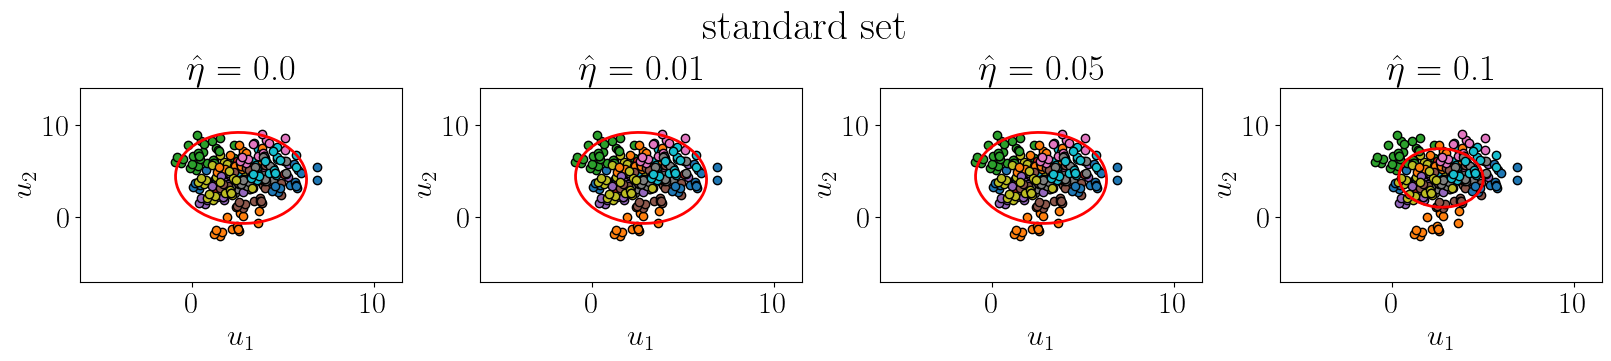

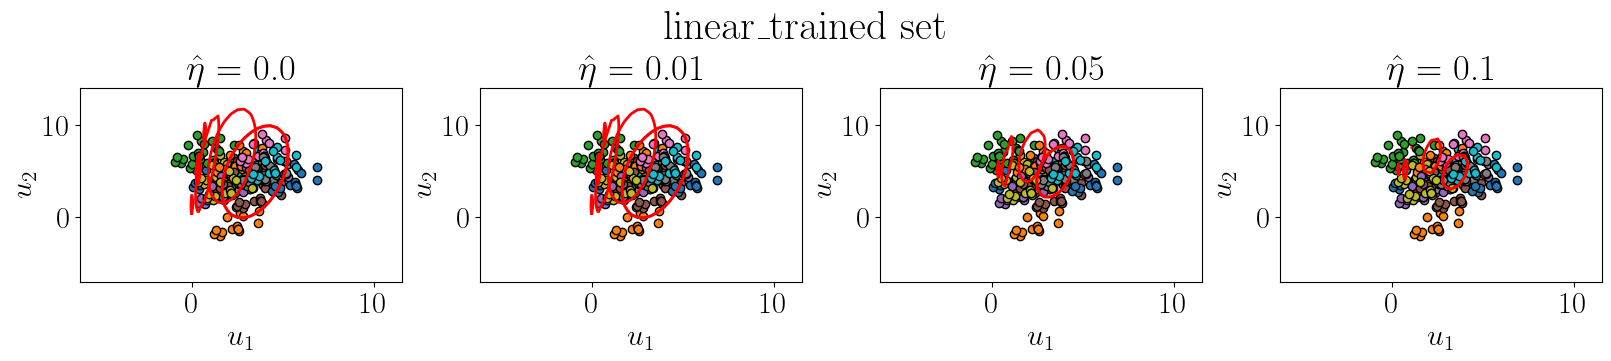

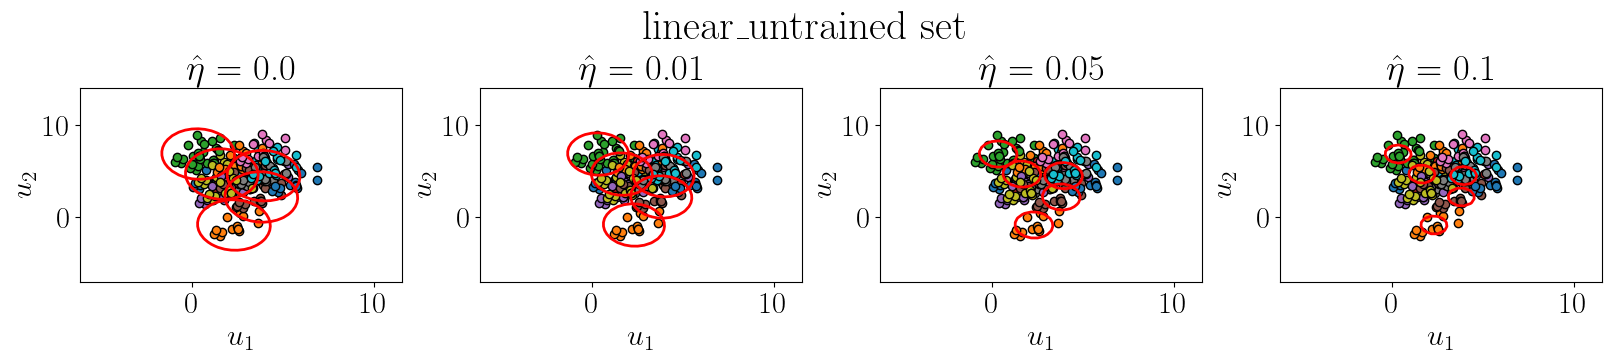

In [130]:
plot_contours_line(x,y,init_set,prob_list,train, "standard") 
plot_contours_line(x,y,fin_set, prob_list,train, "linear_trained", K=5)
plot_contours_line(x,y,untrained_set,prob_list,train, "linear_untrained", K=5)